In [1]:
import numpy as np
import pandas as pd
import pygeostat as gs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess as sp
%pylab inline --no-import-all
from subprocess import check_output
import tensorflow as tf
from tensorflow.python import debug as tf_debug
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn import preprocessing
import scipy.spatial as scs
import scipy as sc
import math
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error
import time
from sklearn.metrics import r2_score
from random import randrange

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
griddef = gs.GridDef(gridfl='griddef.txt')
griddef

Pygeostat GridDef:
50 5.0 10.0 
50 5.0 10.0 
25 5.0 10.0

In [3]:
varmodelpar = '''                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
varmodel.out                 -file for modeled variogram points output
2                            -number of directions to model points along
  45   0.0  1000   0.5      -  azm, dip, npoints, point separation
 135   0.0  1000   0.5      -  azm, dip, npoints, point separation
1    0.01                   -nst, nugget effect
3    0.99    135   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        250    250    150    -a_hmax, a_hmin, a_vert (ranges)
0   100000                   -fit model (0=no, 1=yes), maximum iterations
1.0                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
varcalc.out                  -    experimental output file 1
2   1   4                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     10.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
0      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
varmodelfit.var              -  file to save fit variogram model
'''
varmodel= gs.Program(program='varmodel',parfile='varmodel.par')
varmodel.run(parstr=varmodelpar.format())
varmodelfl = gs.DataFile(flname='varmodel.out',
                       readfl=True)
print(varmodelfl.data.head())

Calling:  ['varmodel', 'varmodel.par']

varmodel version: 1.1.1

  output points file: varmodel.out
  number of directions to model points along:            2
  azm, dip, npoints, pointsep:    45.0000000000000       0.000000000000000E+000
        1000  0.500000000000000     
  azm, dip, npoints, pointsep:    135.000000000000       0.000000000000000E+000
        1000  0.500000000000000     
  nst =           1
 c0 constrained to  1.000000000000000E-002  1.000000000000000E-002
  fit model?            0      100000
  number of variogram files:            1
  variogram file: varcalc.out
  using variograms            1           4
  # pairs wt, inv dist wt, min pairs:            1           1          10
  fixhmaxvert,hmaxvert:            0   10.0000000000000     
  fixhminhmax,hminhmax:            0   1.00000000000000     
  variogram model output file: varmodelfit.var
  Modeling points

varmodel completed successfully

   Variogram Index  Lag Distance  Number of Pairs  Variogram Value  \


In [4]:
varmodelfl = gs.DataFile(flname='varmodel.out',
                       readfl=True)
print(varmodelfl.data.head())

   Variogram Index  Lag Distance  Number of Pairs  Variogram Value  \
0              1.0           0.5              1.0         0.010012   
1              1.0           1.0              1.0         0.010047   
2              1.0           1.5              1.0         0.010107   
3              1.0           2.0              1.0         0.010190   
4              1.0           2.5              1.0         0.010297   

   Variogram Number  Calculation Azimuth  Calculation Dip  
0               1.0                 45.0              0.0  
1               1.0                 45.0              0.0  
2               1.0                 45.0              0.0  
3               1.0                 45.0              0.0  
4               1.0                 45.0              0.0  


In [5]:
varg = ("1    0.01                   -nst, nugget effect\n\
3    0.99    135   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)\n\
        250    250    150    -a_hmax, a_hmin, a_vert (ranges)")

print(varg)

1    0.01                   -nst, nugget effect
3    0.99    135   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        250    250    150    -a_hmax, a_hmin, a_vert (ranges)


In [6]:
sgsimpar = '''                  Parameters for SGSIM
                  ********************

START OF PARAMETERS:
cluster.dat           -file with data
1  2  3  4  0  0              -  columns for X,Y,Z,vr,wt,sec.var.
-1.0       1.0e21             -  trimming limits
0                             -transform the data (0=no, 1=yes)
sgsim.trn                     -  file for output trans table
0                             -  consider ref. dist (0=no, 1=yes)
histsmth.out                  -  file with ref. dist distribution
1  2                          -  columns for vr and wt
0.0    15.0                   -  zmin,zmax(tail extrapolation)
1       0.0                   -  lower tail option, parameter
1      15.0                   -  upper tail option, parameter
1                             -debugging level: 0,1,2,3
sgsim.dbg                     -file for debugging output
sgsim.out                     -file for simulation output
1                             -number of realizations to generate
{grid}
69069                         -random number seed
0     8                       -min and max original data for sim
48                            -number of simulated nodes to use
1                             -assign data to nodes (0=no, 1=yes)
1     3                       -multiple grid search (0=no, 1=yes),num
0                             -maximum data per octant (0=not used)
250  250.0  150.0              -maximum search radii (hmax,hmin,vert)
 0.0   0.0   0.0              -angles for search ellipsoid
51    51    11                -size of covariance lookup table
0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC
../data/ydata.dat             -  file with LVM, EXDR, or COLC variable
4                             -  column for secondary variable
{varg}

'''
sgsim= gs.Program(program='sgsim',parfile='sgsim.par')
sgsim.run(parstr=sgsimpar.format(varg = varg,
                                 grid = griddef
                                ))
sgsimfl = gs.DataFile(flname='sgsim.out', griddef = griddef,
                       readfl=True)
print(sgsimfl.data.head())

Calling:  ['sgsim', 'sgsim.par']

 SGSIM Version: 4.000

  data file = cluster.dat                             
  input columns =            1           2           3           4           0
           0
  trimming limits =   -1.000000      1.0000000E+21
  transformation flag =            0
  transformation file = sgsim.trn                               
  consider smoothed distribution (1=yes) =            0
  file with smoothed distribution = histsmth.out                            
  columns =            1           2
  data limits (tails) =   0.0000000E+00   15.00000    
  lower tail =            1  0.0000000E+00
  upper tail =            1   15.00000    
  debugging level =            1
  debugging file = sgsim.dbg                               
  output file sgsim.out                               
  number of realizations =            1
  X grid specification =           50   5.000000       10.00000    
  Y grid specification =           50   5.000000       10.00000    
  Z grid

In [6]:
sgsimfl = gs.DataFile(flname='sgsim.out', griddef = griddef,
                       readfl=True)
print(sgsimfl.data.describe())

              value
count  62500.000000
mean       0.371670
std        0.775798
min       -2.018213
25%       -0.209773
50%        0.321934
75%        0.889074
max        2.813831


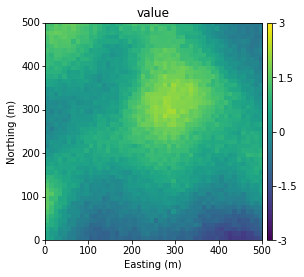

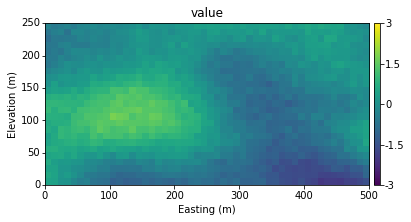

In [7]:
vlim = (-3,3)
gs.pixelplt(sgsimfl,griddef,orient='xy', vlim = vlim)
gs.pixelplt(sgsimfl,griddef,orient='xz', vlim = vlim)


In [8]:
addcoordpar = '''                  Parameters for ADDCOORD
                  ***********************

START OF PARAMETERS:
{datafl}                         -file with data
addcoord.out                      -file for output
1                                 -realization number
{grid}
3 3 6                            -decimals for x, y, z (-1=exclude)
'''
addcoord= gs.Program(program='addcoord',parfile='addcoord.par')
addcoord.run(parstr=addcoordpar.format(datafl=sgsimfl.flname
                                ,grid = griddef
                                ))
addcoordfl = gs.DataFile(flname='addcoord.out', griddef = griddef,
                       readfl=True)
print(addcoordfl.data.head())

Calling:  ['addcoord', 'addcoord.par']

 ADDCOORD VERSION: 4.1.0

 Data File = sgsim.out                               
 Output File = addcoord.out                            
 Realization number =            1
 X grid size =           50   5.00000000000000        10.0000000000000     
 Y grid size =           50   5.00000000000000        10.0000000000000     
 Z grid size =           25   5.00000000000000        10.0000000000000     
 decimals =            3           3           6
 
 Format: (f07.03,x,f07.03,x,f10.06,x,a)      

 ADDCOORD: 4.1.0 Finished

      X    Y    Z     value
0   5.0  5.0  5.0  0.482893
1  15.0  5.0  5.0  0.435116
2  25.0  5.0  5.0  0.116569
3  35.0  5.0  5.0  0.084204
4  45.0  5.0  5.0 -0.211761


In [9]:
datafl = gs.DataFile(flname = 'addcoord.out',x='X',y='Y',z='Z', griddef=griddef,
readfl=True)
print(datafl.data.head())

      X    Y    Z     value
0   5.0  5.0  5.0  0.482893
1  15.0  5.0  5.0  0.435116
2  25.0  5.0  5.0  0.116569
3  35.0  5.0  5.0  0.084204
4  45.0  5.0  5.0 -0.211761


In [10]:
gs.write_gslib(datafl,'addcoord.out')


In [11]:
datafl = gs.DataFile(flname ='addcoord.out',x='X',y='Y',z='Z', griddef=griddef,
readfl=True)

In [12]:
datafl.rename({'value': 'Var1'})

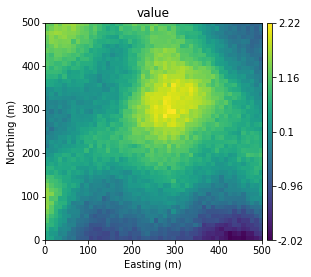

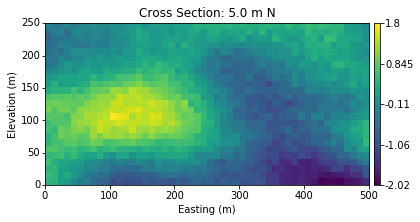

In [13]:
gs.pixelplt(sgsimfl,griddef)
gs.pixelplt(datafl['Var1'], griddef = griddef, orient='xz')

In [14]:
gsamplepar = '''       Parameters for gsample V2.000
     *********************************
       
START OF PARAMETERS:
1                            - Number of files to sample
{datafl}            - File with first grid
1  {varcol1}                        - Number of variables and columns
1                            - Realization to sample
{griddef}
0                            - Sampling spacing option (0=regular, 1=random)
100  100                       -  If 0, spacing in X, Y
50  50                     -  If 0, collar of the first sample, X and Y (inside sampling grid)
80  69069                    -  If 1, number of drill holes and seed number
0  90                        - Azimuth and dip
10                            - Sample spacing downhole
1                          - Starting drill hole ID for new drills
2                            - Number of decimal places (coordinates precision, up to 6)
5   495                       - Sampling grid: xmin, xmax
5   495                       -                ymin, ymax
5   245                       -                zmin, zmax
dhs.out        - Output file with new drill holes
0                            - Output keyout file? (0=no, 1=yes)
0                            -  If keyout (0=input grid inside sampling grid, 1=input blocks with assays)
keyout.out         - Keyout file
'''
gsample= gs.Program(program='gsample',parfile='gsample.par')
gsample.run(parstr=gsamplepar.format(datafl=datafl.flname,
                                       varcol1=datafl.gscol('Var1'),
                                         griddef=griddef
                                      ))

Calling:  ['gsample', 'gsample.par']

GSAMPLE Version: 1.000

PARAMETER FILE                  = gsample.par                                                                                                                                                                                                                                                     
-----------------------------------------------------------------------------

INPUT PARAMETERS 

Number of grids to sample       =   1
Total number of variables       =   1
 
Data file  1                    = 
addcoord.out
Variable columns                =   4
 
Sample realization number       =   1
 
Input grid 
Input grid in X                 =   50        5.00   10.00
Input grid in Y                 =   50        5.00   10.00
Input grid in Z                 =   25        5.00   10.00
 
Sample option                   =   0
 
Consider regular spacing 

 
Spacing in X                    =   100.0    
Spacing in Y                    =   1

In [15]:
dataflpoints = gs.DataFile(flname='dhs.out', x='X',y='Y',z='Z', griddef = griddef,
                       readfl=True)
print(dataflpoints.data.head())
dataflpoints.describe()

   Drill ID     X     Y      Z    MD  Block ID   value
0       1.0  50.0  50.0  245.0   0.0   60256.0 -0.2301
1       1.0  50.0  50.0  235.0  10.0   57756.0 -0.1845
2       1.0  50.0  50.0  225.0  20.0   55256.0 -0.1333
3       1.0  50.0  50.0  215.0  30.0   52756.0 -0.0725
4       1.0  50.0  50.0  205.0  40.0   50256.0 -0.0517


,Drill ID,MD,Block ID,value
count,600.000000,600.000000,600.000000,600.000000
mean,13.000000,115.000000,32526.000000,0.367402
std,7.217119,69.279623,17334.363759,0.762382
min,1.000000,0.000000,2756.000000,-1.088800
25%,7.000000,57.500000,17641.000000,-0.178750
50%,13.000000,115.000000,32526.000000,0.329350
75%,19.000000,172.500000,47411.000000,0.918200
max,25.000000,230.000000,62296.000000,2.652200


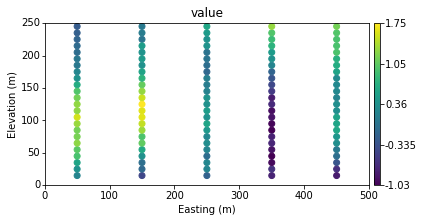

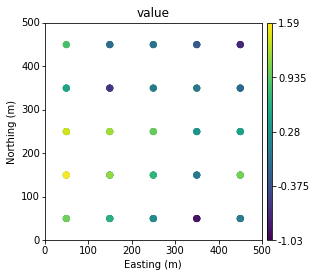

In [16]:
gs.locmap(dataflpoints,var = 'value',orient='xz')
gs.locmap(dataflpoints,var = 'value',orient='xy')

In [17]:
datasamplefl = pd.DataFrame(dataflpoints.data, dtype = np.float32)
del datasamplefl['Drill ID']
del datasamplefl['MD']
del datasamplefl['Block ID']
datasamplefl['Z'] = datasamplefl['Z']

In [18]:
datasamplefl = datasamplefl[pd.notnull(datasamplefl['value'])]
datasamplefl.describe()

,X,Y,Z,value
count,600.000000,600.000000,600.000000,600.000000
mean,250.000000,250.000000,130.000000,0.367402
std,141.539352,141.539352,69.279625,0.762382
min,50.000000,50.000000,15.000000,-1.088800
25%,150.000000,150.000000,72.500000,-0.178750
50%,250.000000,250.000000,130.000000,0.329350
75%,350.000000,350.000000,187.500000,0.918200
max,450.000000,450.000000,245.000000,2.652200


In [19]:
gs.write_gslib(datasamplefl, 'datasamplefl.out')

In [20]:
datatest = np.asarray(datasamplefl)

In [434]:
tf.InteractiveSession.close(sess)
sess.close()

TypeError: super(type, obj): obj must be an instance or subtype of type

In [21]:
SMALL_SIZE = 15
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)

-1.0888
2.6522
1
starting Tensorflow Session
Epoch : 0
Cost_train : 813186.94
Cost_test: 757948.25
r2: -20395504.0
Epoch : 1
Cost_train : 226212.89
Cost_test: 209824.4
r2: -5646129.5
Epoch : 2
Cost_train : 90567.625
Cost_test: 83576.57
r2: -2248947.0
Epoch : 3
Cost_train : 43206.098
Cost_test: 39642.4
r2: -1066729.9
Epoch : 4
Cost_train : 22761.625
Cost_test: 20745.82
r2: -558244.9
Epoch : 5
Cost_train : 12755.736
Cost_test: 11536.052
r2: -310420.72
Epoch : 6
Cost_train : 7462.573
Cost_test: 6688.796
r2: -179986.7
Epoch : 7
Cost_train : 4528.591
Cost_test: 4019.4204
r2: -108156.92
Epoch : 8
Cost_train : 2862.083
Cost_test: 2516.222
r2: -67707.6
Epoch : 9
Cost_train : 1906.3097
Cost_test: 1663.9586
r2: -44774.188
Epoch : 10
Cost_train : 1354.2866
Cost_test: 1178.8407
r2: -31720.232
Epoch : 11
Cost_train : 1026.9869
Cost_test: 895.6466
r2: -24099.809
Epoch : 12
Cost_train : 818.68
Cost_test: 717.2372
r2: -19299.018
Epoch : 13
Cost_train : 670.0256
Cost_test: 589.71747
r2: -15867.61
Epoch

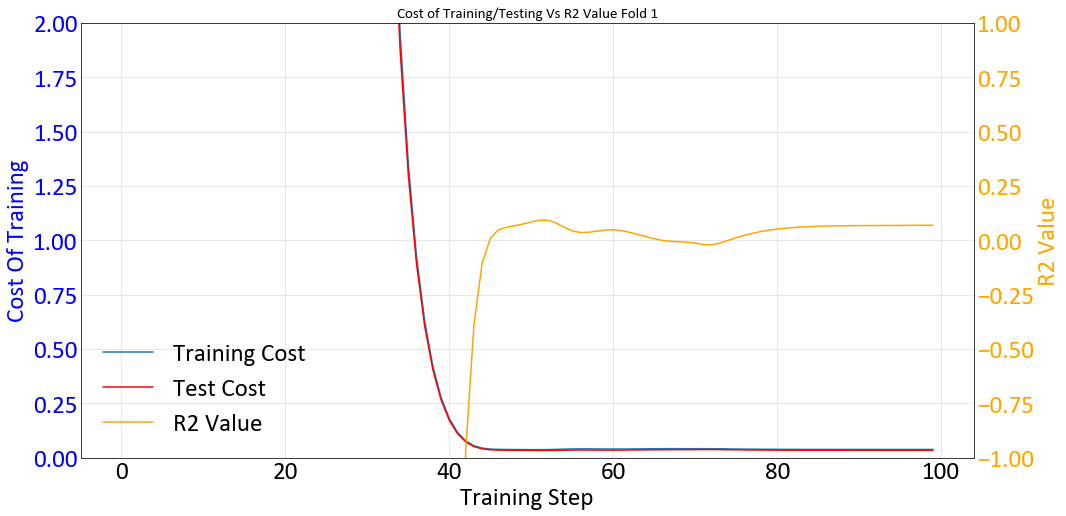

Model Saved
2
starting Tensorflow Session
Epoch : 0
Cost_train : 796468.7
Cost_test: 812985.56
r2: -18190272.0
Epoch : 1
Cost_train : 221824.39
Cost_test: 229487.9
r2: -5134712.0
Epoch : 2
Cost_train : 88849.15
Cost_test: 93139.984
r2: -2083974.2
Epoch : 3
Cost_train : 42387.043
Cost_test: 45056.973
r2: -1008133.25
Epoch : 4
Cost_train : 22326.322
Cost_test: 24094.088
r2: -539095.94
Epoch : 5
Cost_train : 12510.384
Cost_test: 13724.553
r2: -307081.16
Epoch : 6
Cost_train : 7321.4556
Cost_test: 8171.77
r2: -182839.55
Epoch : 7
Cost_train : 4449.119
Cost_test: 5048.2114
r2: -112951.0
Epoch : 8
Cost_train : 2820.8408
Cost_test: 3240.5808
r2: -72505.88
Epoch : 9
Cost_train : 1889.1133
Cost_test: 2178.5251
r2: -48742.754
Epoch : 10
Cost_train : 1351.6802
Cost_test: 1546.3148
r2: -34597.266
Epoch : 11
Cost_train : 1032.3381
Cost_test: 1159.1364
r2: -25934.277
Epoch : 12
Cost_train : 827.43915
Cost_test: 907.0515
r2: -20293.967
Epoch : 13
Cost_train : 679.4192
Cost_test: 727.26154
r2: -16271.

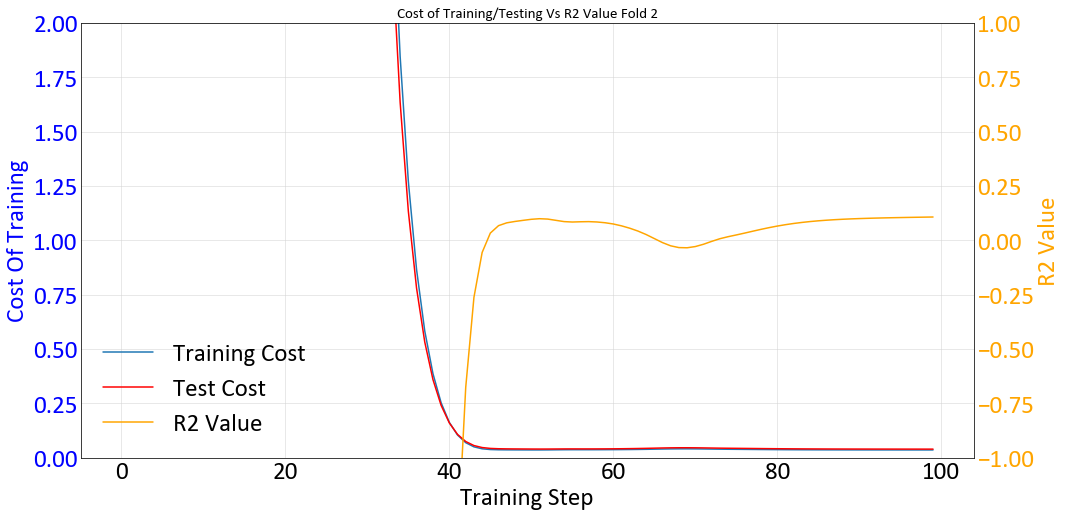

Model Saved
3
starting Tensorflow Session
Epoch : 0
Cost_train : 783715.94
Cost_test: 832747.0
r2: -19315552.0
Epoch : 1
Cost_train : 217934.42
Cost_test: 231543.86
r2: -5370655.5
Epoch : 2
Cost_train : 87199.0
Cost_test: 92651.086
r2: -2149039.5
Epoch : 3
Cost_train : 41568.84
Cost_test: 44177.266
r2: -1024690.06
Epoch : 4
Cost_train : 21883.338
Cost_test: 23264.906
r2: -539628.2
Epoch : 5
Cost_train : 12257.544
Cost_test: 13038.388
r2: -302424.22
Epoch : 6
Cost_train : 7172.3726
Cost_test: 7634.8804
r2: -177089.94
Epoch : 7
Cost_train : 4359.0967
Cost_test: 4644.5425
r2: -107729.1
Epoch : 8
Cost_train : 2764.8916
Cost_test: 2949.1475
r2: -68404.43
Epoch : 9
Cost_train : 1852.2988
Cost_test: 1977.9233
r2: -45876.902
Epoch : 10
Cost_train : 1324.8138
Cost_test: 1416.0386
r2: -32843.992
Epoch : 11
Cost_train : 1009.94653
Cost_test: 1080.3671
r2: -25058.098
Epoch : 12
Cost_train : 806.7454
Cost_test: 863.7071
r2: -20032.674
Epoch : 13
Cost_train : 659.5573
Cost_test: 706.88086
r2: -16395

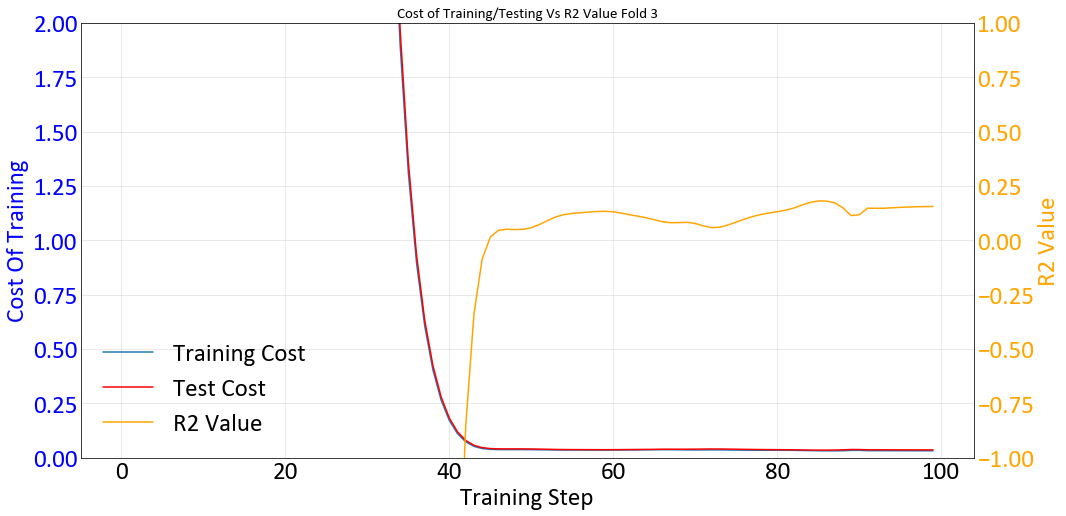

Model Saved
4
starting Tensorflow Session
Epoch : 0
Cost_train : 809458.2
Cost_test: 787950.44
r2: -17917536.0
Epoch : 1
Cost_train : 225280.25
Cost_test: 221096.94
r2: -5027615.0
Epoch : 2
Cost_train : 90215.15
Cost_test: 89212.62
r2: -2028642.0
Epoch : 3
Cost_train : 43048.945
Cost_test: 42891.06
r2: -975316.75
Epoch : 4
Cost_train : 22689.965
Cost_test: 22778.375
r2: -517966.0
Epoch : 5
Cost_train : 12728.584
Cost_test: 12873.678
r2: -292738.97
Epoch : 6
Cost_train : 7461.5967
Cost_test: 7597.3813
r2: -172759.03
Epoch : 7
Cost_train : 4543.945
Cost_test: 4648.2373
r2: -105697.22
Epoch : 8
Cost_train : 2887.3499
Cost_test: 2955.454
r2: -67204.31
Epoch : 9
Cost_train : 1936.4004
Cost_test: 1971.4009
r2: -44827.51
Epoch : 10
Cost_train : 1384.8326
Cost_test: 1393.5349
r2: -31687.174
Epoch : 11
Cost_train : 1054.5411
Cost_test: 1045.2445
r2: -23767.254
Epoch : 12
Cost_train : 841.1094
Cost_test: 821.91235
r2: -18688.81
Epoch : 13
Cost_train : 686.6582
Cost_test: 664.13727
r2: -15101.095

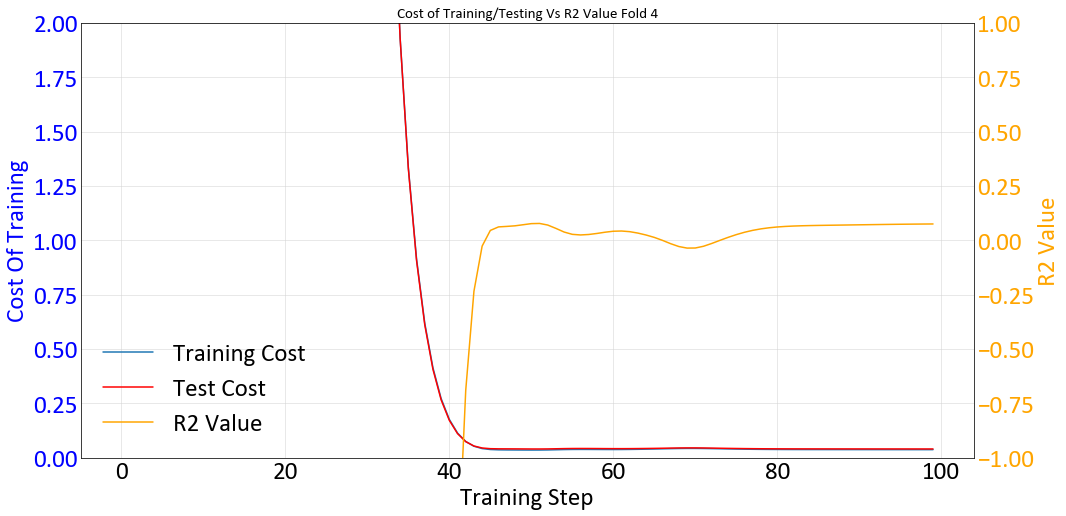

Model Saved
5
starting Tensorflow Session
Epoch : 0
Cost_train : 794659.94
Cost_test: 806436.94
r2: -21607780.0
Epoch : 1
Cost_train : 220662.14
Cost_test: 220264.7
r2: -5901801.5
Epoch : 2
Cost_train : 88276.27
Cost_test: 86718.9
r2: -2323557.0
Epoch : 3
Cost_train : 42097.37
Cost_test: 40672.75
r2: -1089790.1
Epoch : 4
Cost_train : 22173.504
Cost_test: 21047.121
r2: -563938.44
Epoch : 5
Cost_train : 12424.525
Cost_test: 11575.312
r2: -310149.47
Epoch : 6
Cost_train : 7267.003
Cost_test: 6646.2314
r2: -178079.02
Epoch : 7
Cost_train : 4407.1235
Cost_test: 3969.0017
r2: -106344.98
Epoch : 8
Cost_train : 2781.5112
Cost_test: 2487.503
r2: -66649.49
Epoch : 9
Cost_train : 1848.1733
Cost_test: 1665.7863
r2: -44632.3
Epoch : 10
Cost_train : 1308.505
Cost_test: 1209.5638
r2: -32408.217
Epoch : 11
Cost_train : 988.4977
Cost_test: 948.30316
r2: -25407.965
Epoch : 12
Cost_train : 785.29944
Cost_test: 782.87054
r2: -20975.34
Epoch : 13
Cost_train : 641.05554
Cost_test: 659.8965
r2: -17680.355
Ep

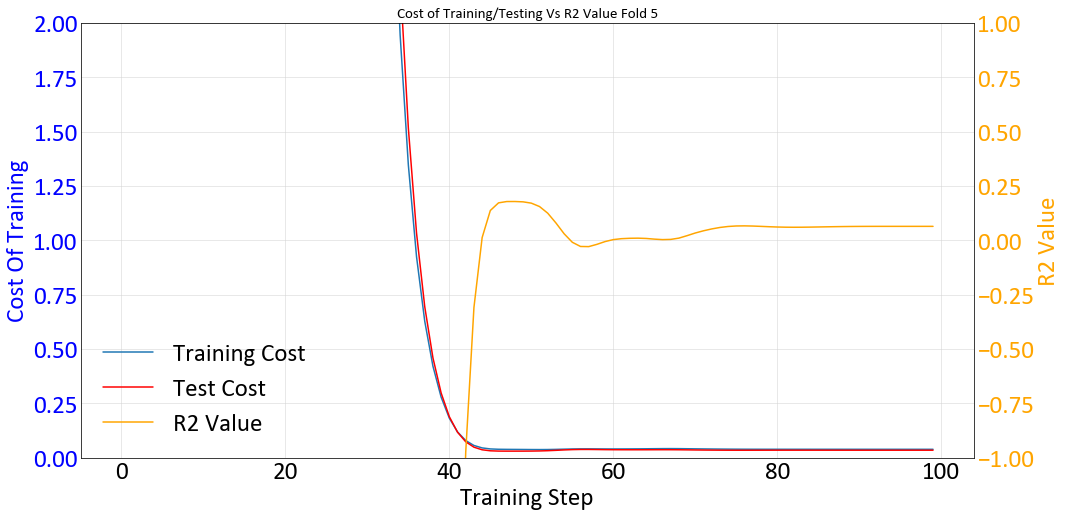

Model Saved


In [349]:
from sklearn.model_selection import KFold
#Prediction Grid
x,y,z = griddef.gridcoord()
#DH Sample Data
datatest = np.asarray(datasamplefl)
min_val = np.min(datatest[:,3])
max_val = np.max(datatest[:,3])
print(min_val)
print(max_val)
datatest[:,3] = (datatest[:,3]-min_val)/(max_val-min_val)
data_x = np.hstack((x.reshape(len(x),1),y.reshape(len(y),1),z.reshape(len(z),1)))/100
kf = KFold(n_splits = 5, shuffle=True)
kf.get_n_splits(datatest)
fold_num= 0
columns = ['X','Y','Z','value']
n_batch = 1
for train_index, test_index in kf.split(datatest):
    fold_num += 1
    print(fold_num)
    #print("TRAIN:", train_index, "TEST:", test_index)
    data_train, data_test = datatest[train_index,0:3]/100, datatest[test_index,0:3]/100
    target_train, target_test = datatest[train_index,3:4], datatest[test_index,3:4]
    gs.write_gslib(pd.DataFrame(np.hstack((data_train*100,target_train*(max_val-min_val)+min_val)),columns=columns), './data/data_train_{}.dat'.format(fold_num))
    gs.write_gslib(pd.DataFrame(np.hstack((data_test*100,target_test*(max_val-min_val)+min_val)),columns=columns), './data/data_test_{}.dat'.format(fold_num))    
    c_t = []
    c_test = []
    c_r2 = []
    with tf.device('/device:GPU:0'):
        
        
        tf.reset_default_graph()
        
        with tf.name_scope('input'):
            xs = tf.placeholder("float", name = 'xs')
            ys = tf.placeholder("float", name = 'ys')
        X_data = xs
        input_feature = data_train.shape[1]
        layer1_2_cross = 25
        layer2_o_cross = 25
        layer2_O_cross = 25
        with tf.name_scope('Input_Layer') as scope:
            W1 = tf.Variable(np.ones((input_feature,layer1_2_cross),np.float32), name ='Weights1')
            b1 = tf.Variable([0],name='bias1',dtype=tf.float32)
            layer1 = tf.add(tf.matmul(X_data,W1), b1, name = 'layer1_op')
            
        with tf.name_scope('Hidden_Layer') as scope:
            W2 = tf.Variable(np.ones((layer1_2_cross,layer2_o_cross),np.float32), name ='Weights2')
            b2 = tf.Variable([0],name='bias2',dtype=tf.float32)
            layer2 = tf.add(tf.matmul(layer1,W2), b2, name = 'layer2_op')
        #layer1 = tf.nn.softplus(layer1)

        #keep_prob = tf.placeholder(tf.float32)
        #drop_out = tf.nn.dropout(layer1,keep_prob)

        #W2 = tf.Variable(np.ones((layer1_2_cross,layer2_O_cross),np.float32), name ='Weights2')
        #b2 = tf.Variable([0.],name='bias2')
        #layer2 = tf.add(tf.matmul(layer1,W2), b2, name = 'layer2_op')
        #layer2 = tf.nn.softplus(layer2)

        with tf.name_scope('Output_Layer') as scope:
            WO = tf.Variable(np.ones((layer2_O_cross,1),np.float32), name ='Weightsout')
            bO = tf.Variable([0],name='biasout',dtype=tf.float32)
            output = tf.add(tf.matmul(layer2,WO), bO, name = 'output')
        #output = tf.nn.tanh(output)
        with tf.name_scope('Cost'):
            cost = tf.reduce_mean(tf.squared_difference(output,ys))

        LR = 0.001
        #train = tf.train.GradientDescentOptimizer(LR).minimize(cost)
        #train = tf.train.RMSPropOptimizer(LR).minimize(cost)
        train = tf.train.AdamOptimizer(LR).minimize(cost)
        counter2 = 0
        with tf.name_scope('accuracy'):
            total_error = tf.reduce_sum(tf.square(tf.subtract(ys, tf.reduce_mean(ys))))
            unexplained_error = tf.reduce_sum(tf.square(tf.subtract(ys, output)))
            accuracy = tf.subtract(1.00, tf.divide(unexplained_error, total_error))
        print('starting Tensorflow Session')
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            saver = tf.train.Saver()
            #saver.restore(sess, 'C:/Users/Matt/Desktop/Research/06.19.2018/test_dataset150.ckpt')

            for i in range(100):
                counter2 = counter2 +1 
                for j in range (data_train.shape[0]):
                    #sess.run([cost,train,W1,b1,output],feed_dict={xs:X_train[j,:].reshape(1,m), ys:y_train[j]})
                    sess.run([cost,train],feed_dict={xs:data_train[j,:].reshape(1,input_feature), ys:target_train[j]})
                c_t.append(sess.run(cost, feed_dict={xs:data_train,ys:target_train}))
                c_test.append(sess.run(cost, feed_dict={xs:data_test,ys:target_test}))
                c_r2.append(sess.run(accuracy, feed_dict={xs:data_test,ys:target_test}))
                print('Epoch :',i)
                print('Cost_train :',c_t[i])
                print('Cost_test:',c_test[i])
                print('r2:',c_r2[i])
                if counter2 == 5 :
                    #saver.save(sess,'C:/Users/Matt/Desktop/Research/07.19.2018/test_dataset{}.ckpt'.format(i))
                    counter2 = 0

                if c_t[i] <= 0.030:
                    saver.save(sess,'test/test_dataset_{}_{}.ckpt'.format(i,fold_num))
                    summaries_dir = ('test/test_dataset_{}_{}.ckpt'.format(i,fold_num))
                    pred = sess.run(output, feed_dict={xs:data_test})
                    print('Cost_train :',sess.run(cost, feed_dict={xs:data_train,ys:target_train}))
                    print('Cost_test :',sess.run(cost, feed_dict={xs:data_test,ys:target_test}))           

                    plt.plot(range(target_test.shape[0]),target_test,label="Original Data")
                    plt.plot(range(target_test.shape[0]),pred,label="Predicted Data")
                    plt.legend(loc='best')
                    plt.ylabel('Grade Value')
                    plt.xlabel('Grade Point')
                    plt.title('Grade Estimates')
                    plt.show()

                    plt.plot(range(len(c_t)),c_t,label="Train Cost")
                    plt.plot(range(len(c_t)),c_test,label="Test Cost")
                    plt.legend(loc='best')
                    plt.ylabel('Epoch')
                    plt.xlabel('Cost')
                    plt.title('Training vs. Test Cost')
                    plt.show()
                    break

            pred = sess.run(output, feed_dict={xs:data_x})
            pred1 = pred*(max_val-min_val)+min_val
            gs.write_gslib(pd.DataFrame(pred1), './predictions/real_{}.dat'.format(fold_num))

            print('Cost_train :',sess.run(cost, feed_dict={xs:data_train,ys:target_train}))
            print('Cost_test :',sess.run(cost, feed_dict={xs:data_test,ys:target_test}))           

            
            SMALL_SIZE = 15
            plt.rc('font', size=SMALL_SIZE)
            plt.rc('axes', titlesize=SMALL_SIZE)
            f, (ax1) = plt.subplots(1, 1,figsize=(16, 8))
            ax1.set_ylim([0,2])
            ax1.plot(range(len(c_t)), c_t, label ='Training Cost')
            ax1.plot(range(len(c_t)), c_test, color="red",label ='Test Cost')
            ax1.set_xlabel('Training Step')
            ax1.grid(True)
            ax1.set_title('Cost of Training/Testing Vs R2 Value Fold {}'.format(fold_num))
            ax1.set_ylabel('Cost Of Training', color='blue')
            ax1.tick_params(axis='y', labelcolor='blue')
            ax2 = ax1.twinx()
            ax2.plot(range(len(c_t)), c_r2,'-',color="orange",label ='R2 Value')
            ax2.set_ylim([-1,1])
            ax2.set_ylabel('R2 Value', color='orange')
            ax2.tick_params(axis='y', labelcolor='orange')
            lines, labels = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax2.legend(lines + lines2, labels + labels2, loc=3)
            plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/Training_R2_01_{}.png'.format(fold_num))
            plt.show()
        
            writer = tf.summary.FileWriter("sess_graph", sess.graph)
            saver.save(sess,'test/test_dataset_{}.ckpt'.format(fold_num))
            
            
            
            print('Model Saved')    

In [344]:
varcparstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{datafl}                 -file with data
{xyzcol}                         -   columns for X, Y, Z coordinates
1   {varcol}                            -   number of variables,column numbers (position used for tail,head variables below)
-99.0    1.0e21                  -   trimming limits
3                                 -number of directions
135 22.5 200 0.0 22.5 200 0.0   -Dir 01: azm,azmtol,bandhorz,dip,dipt
 20  100  50                 -        number of lags,lag distanc
45 22.5 200 0.0 22.5 200 0.0   -Dir 02: azm,azmtol,bandhorz,dip,dipt
 20  100  50                 -        number of lags,lag distanc
0. 22.5 200 90.0 22.5 200 0.0   -Dir 03: azm,azmtol,bandhorz,dip,
 20  5.0  2.5                 -        number of lags,lag distanc
./vargs/varcalc_{fold}.out                       -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1   1   ?                     -tail variable, head variable, variogram type (and cutoff/category), sill



NOTES ON VARIOGRAM CALCULATION:
1) By default, varcalc runs checks for common errors in parameter choices. This can be
   disabled if desired. 
2) Varcalc can standardize using a provided sill (such as a declustered variance).
   For example, if variable 1 has a declustered variance of 8.6, the traditional
   semivariogram could be standardized by setting the variogram type to:
      1  1  1  8.6
   Alternatively, varcalc can attempt to infer a sill for standardizing by setting
   the variogram type to:
      1  1  1  ?
   The calculated sills will be written to the console. 
3) Variogram types are the same as in GSLIB:
      1 = traditional semivariogram
      2 = traditional cross semivariogram
      3 = covariance   (-3 calculates variance (provided sill) -covariance)
      4 = correlogram  (-4 calculates 1-correlation)
      5 = general relative semivariogram
      6 = pairwise relative semivariogram
      7 = semivariogram of logarithms
      8 = semimadogram
      9 = indicator semivariogram - continuous  - requires a cutoff
      10= indicator semivariogram - categorical - requires a category
4) For indicator variograms, the variogram cutoff/categories are specified immediately after the variogram type
    1   1   9   1.0   ?               -tail variable, head variable, variogram type (and cutoff/category), sill
5) If desired, the program can write out the variogram points in the gamv2004 style
   for compatibility with older versions. Tilt was not supported in pre-varcalc experimental variogram
   programs so use carefully. 
"""
varmparstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
./vargs/varmodel_{fold}.out                 -file for modeled variogram points output
3                            -number of directions to model points along
  135   0.0  1000   0.5      -  azm, dip, npoints, point separation
  45    0.0  1000   0.5      -  azm, dip, npoints, point separation
    0.0  90.0  1000   0.5      -  azm, dip, npoints, point separation
2    0.01                   -nst, nugget effect
3    0:0.99    135   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        100:300     100:300     50:500    -a_hmax, a_hmin, a_vert (ranges)
3    0:0.99    135   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        100:300     100:300     50:500    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1.0                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{varcalc}                  -    experimental output file 1
3   1  2  3                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     10.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
0      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
./vargs/varmodel_{fold}.var              -  file to save fit variogram model
"""
kt3dnparstr = """                 Parameters for KT3DN
                 ********************
START OF PARAMETERS:
{datafl}             -file with data
0  {xyzcol} {varcol}  0                 -  columns for DH,X,Y,Z,var,sec var
-998.0    1.0e21                 -  trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
1   2   0    3    0              -   columns for X,Y,Z,vr and sec var
kt3dn_dataspacing.out            -data spacing analysis output file (see note)
0    15.0                        -  number to search (0 for no dataspacing analysis, rec. 10 or 20) and composite length
0    100   0                     -debugging level: 0,3,5,10; max data for GSKV;output total weight of each data?(0=no,1=yes)
kt3dn.dbg-nkt3dn.sum             -file for debugging output (see note)
./predictions/kt3dn_{fold}.out                        -file for kriged output (see GSB note)
{griddef}
1    1      1                    -x,y and z block discretization
25    50    12    1               -min, max data for kriging,upper max for ASO,ASO incr
0      0                         -max per octant, max per drillhole (0-> not used)
500.0  500.0  250.0              -maximum search radii
135.0  0.0   0.0                 -angles for search ellipsoid
0                                -0=SK,1=OK,2=LVM(resid),3=LVM((1-w)*m(u))),4=colo,5=exdrift,6=ICCK
0.367 0.6  0.8                  -  mean (if 0,4,5,6), corr. (if 4 or 6), var. reduction factor (if 4)
0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                -0, variable; 1, estimate trend
extdrift.out                     -gridded file with drift/mean
4                                -  column number in gridded file
keyout.out                       -gridded file with keyout (see note)
0    1                           -  column (0 if no keyout) and value to keep
{varg}
"""

In [345]:
varcalc = gs.Program('varcalc')
varmodel = gs.Program('varmodel')
kt3dn = gs.Program('kt3dn')
for fold in range(1,6):
    Traindat = gs.DataFile('./data/data_train_{}.dat'.format(fold))

    

    varcalc.run(varcparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('value'),
                             fold = fold))

    varcalcfl = gs.DataFile('./vargs/varcalc_{}.out'.format(fold))

   
    varmodel.run(varmparstr.format(varcalc = varcalcfl.flname,
                                 fold = fold))

    varmodelfl = gs.DataFile('./vargs/varmodel_{}.out'.format(fold))

    f = open("./vargs/varmodel_{}.var".format(fold), "r")
    varg = f.readlines()
    f.close()
    varg = ''.join(varg)
    
    kt3dn.run(kt3dnparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('value'),
                             griddef = griddef,
                             varg = varg,
                             fold = fold))

Calling:  ['varcalc', 'temp']

varcalc version:  1.400

  data file: ./data/data_train_1.dat
  x,y,z columns:            1           2           3
  number of variables:            1
  Variable columns:            4
  tmin,tmax:   -99.0000000000000       1.000000000000000E+021
  number of directions:            3
  direction parameters:
 azm,azmtol,bandhorz   135.000000000000        22.5000000000000     
   200.000000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   200.000000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          20   100.000000000000     
   50.0000000000000     
 azm,azmtol,bandhorz   45.0000000000000        22.5000000000000     
   200.000000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   200.000000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          20   100.000000000000     
   50.0000000000000     
 azm,azmtol,bandhorz  0.000000000000000E+000   22.500000000

 Final objective value =   1.229294202676664E-002
  Modeling points

varmodel completed successfully

Calling:  ['kt3dn', 'temp']

 KT3DN Version: 7.100

  data file = ./data/data_train_2.dat                 
  columns =            0           1           2           3           4
           0
  trimming limits =   -998.000000000000       1.000000000000000E+021
  kriging option =            0
  jackknife data file = xvk.dat                                 
  columns =            1           2           0           3           0
  data spacing analysis output file = kt3dn_dataspacing.out                   
  debugging level =            0
  summary only file = kt3dn.sum                               
  debugging file = kt3dn.dbg                               
  GSLIB-style output file = ./predictions/kt3dn_2.out               
  nx, xmn, xsiz =           50   5.00000000000000        10.0000000000000     
  ny, ymn, ysiz =           50   5.00000000000000        10.0000000000000     
  nz

   currently on estimate      6250
   currently on estimate     12500
   currently on estimate     18750
   currently on estimate     25000
   currently on estimate     31250
   currently on estimate     37500
   currently on estimate     43750
   currently on estimate     50000
   currently on estimate     56250
   currently on estimate     62500

 KT3DN Version:    7.100 Finished

Calling:  ['varcalc', 'temp']

varcalc version:  1.400

  data file: ./data/data_train_4.dat
  x,y,z columns:            1           2           3
  number of variables:            1
  Variable columns:            4
  tmin,tmax:   -99.0000000000000       1.000000000000000E+021
  number of directions:            3
  direction parameters:
 azm,azmtol,bandhorz   135.000000000000        22.5000000000000     
   200.000000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   200.000000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          20   100.000000000000     


varmodel version: 1.1.1

  output points file: ./vargs/varmodel_5.out
  number of directions to model points along:            3
  azm, dip, npoints, pointsep:    135.000000000000       0.000000000000000E+000
        1000  0.500000000000000     
  azm, dip, npoints, pointsep:    45.0000000000000       0.000000000000000E+000
        1000  0.500000000000000     
  azm, dip, npoints, pointsep:   0.000000000000000E+000   90.0000000000000     
        1000  0.500000000000000     
  nst =           2
 c0 constrained to  1.000000000000000E-002  1.000000000000000E-002
  fit model?            1      100000
  number of variogram files:            1
  variogram file: ./vargs/varcalc_5.out
  using variograms            1           2           3
  # pairs wt, inv dist wt, min pairs:            1           1          10
  fixhmaxvert,hmaxvert:            0   10.0000000000000     
  fixhminhmax,hminhmax:            0   1.00000000000000     
  variogram model output file: ./vargs/varmodel_5.var
 Read

In [5]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter('ignore')
from scipy.ndimage import gaussian_filter

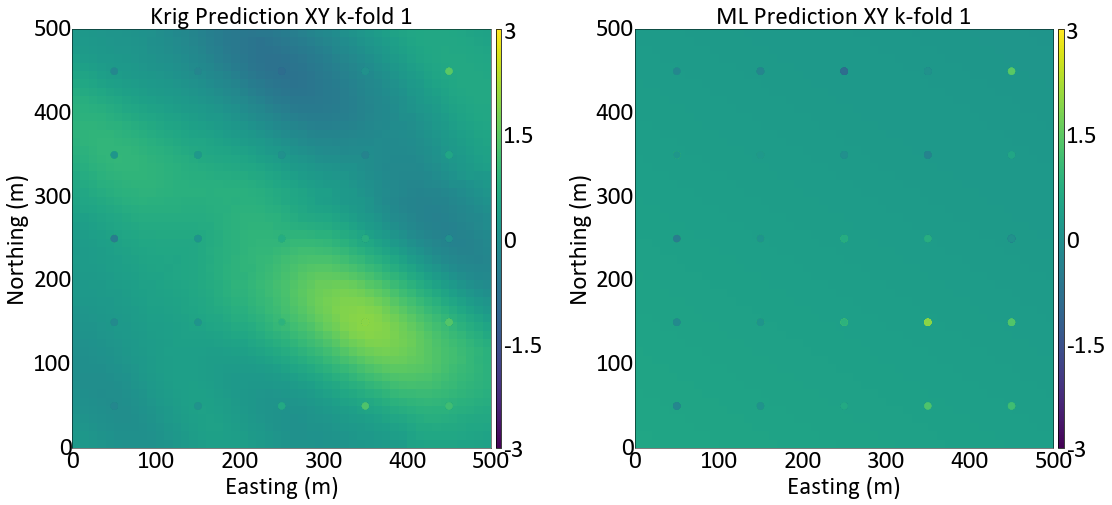

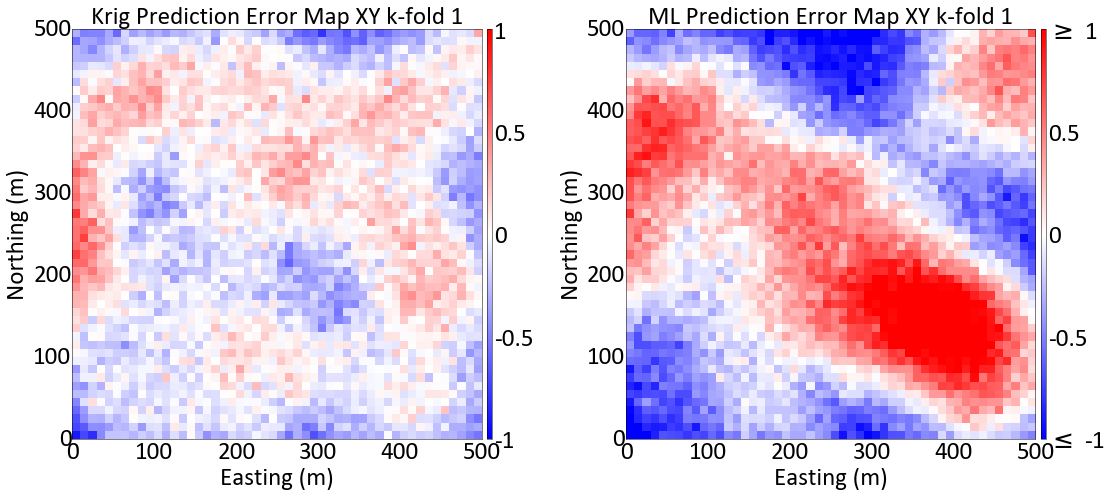

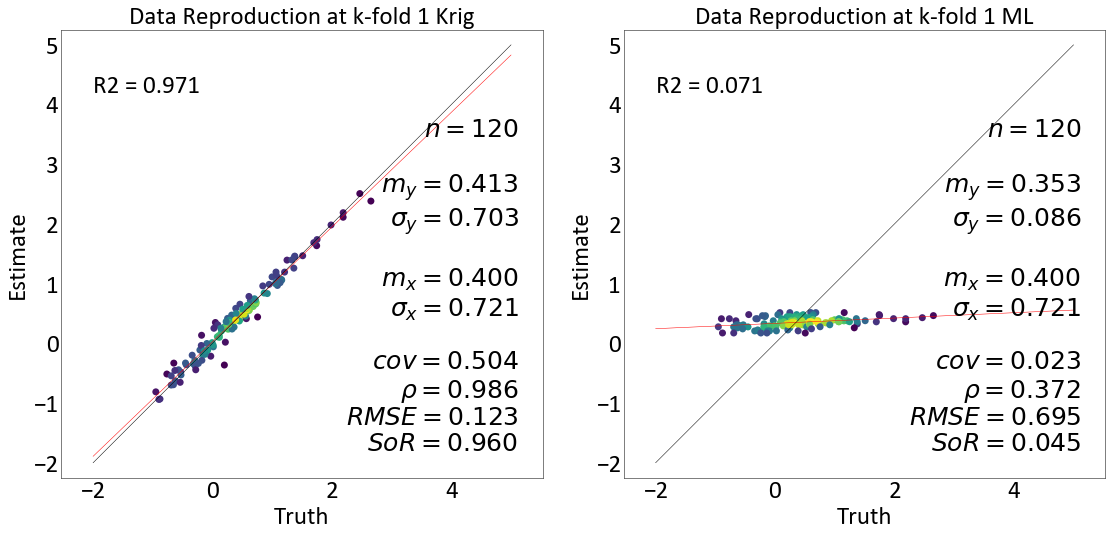

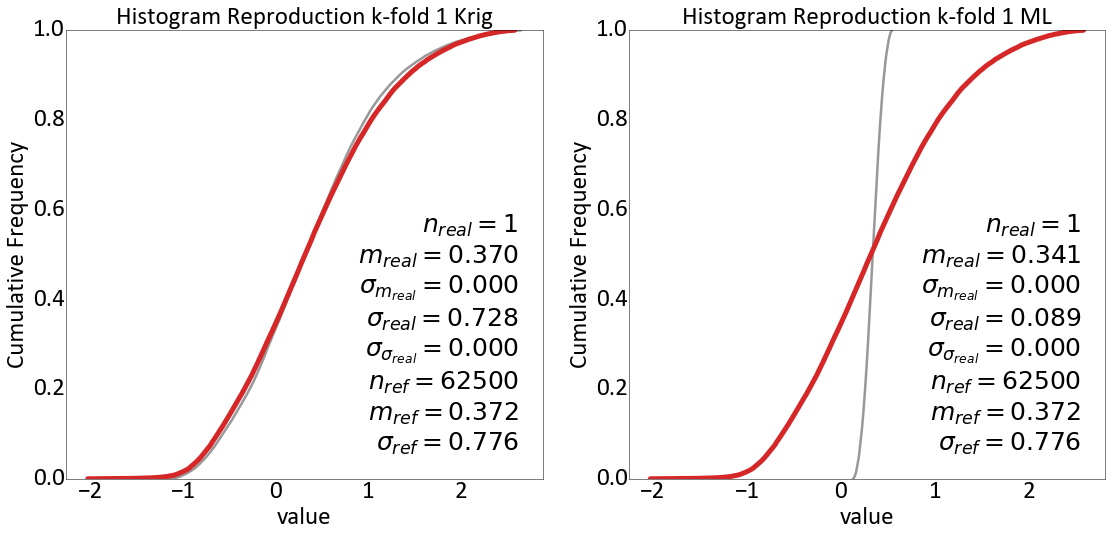

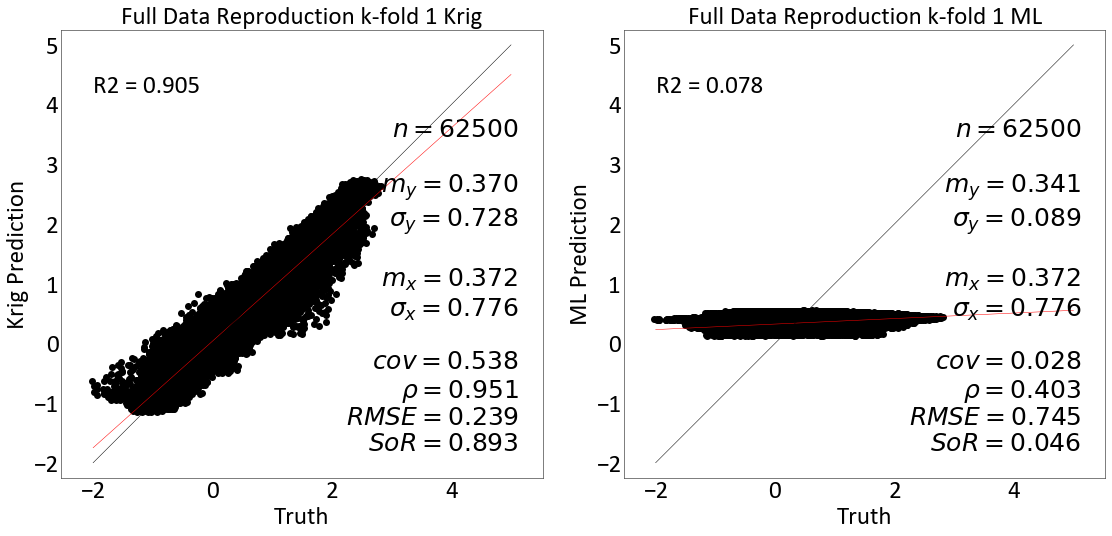

the r2 for krig k-fold 0.9711458461733949
the r2 for ML k-fold 0.07059614770529599
the r2 for krig full 0.9049722231155045
the r2 for ML full 0.07760699656613101


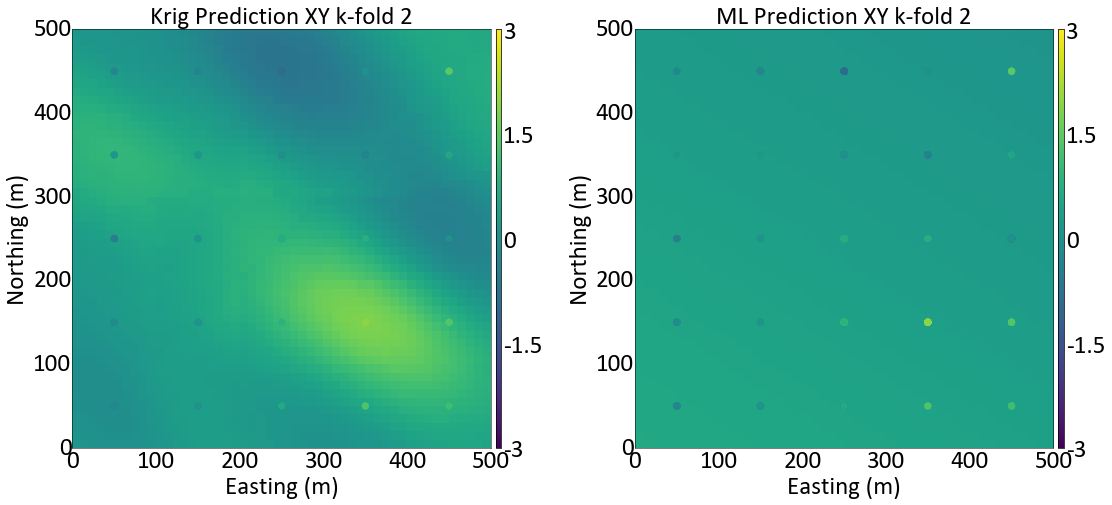

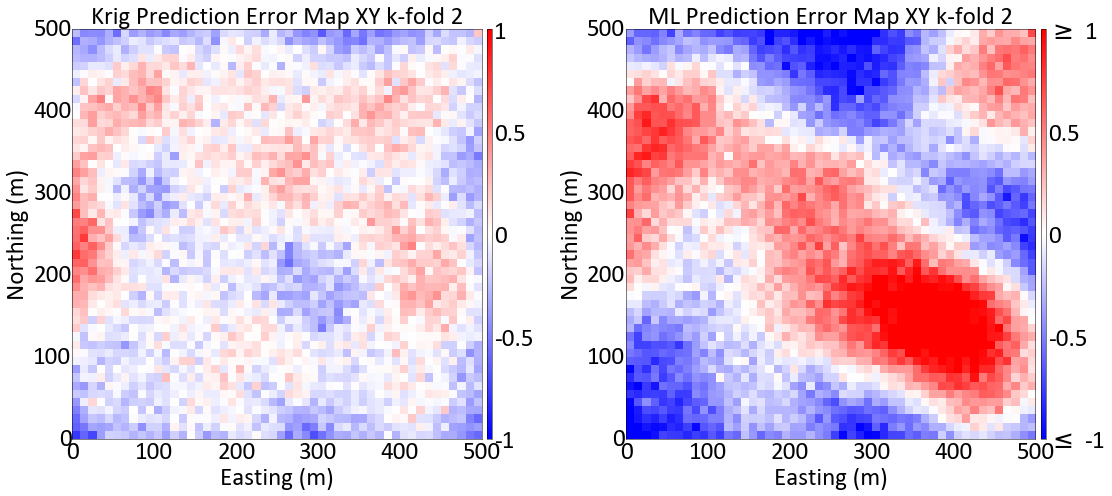

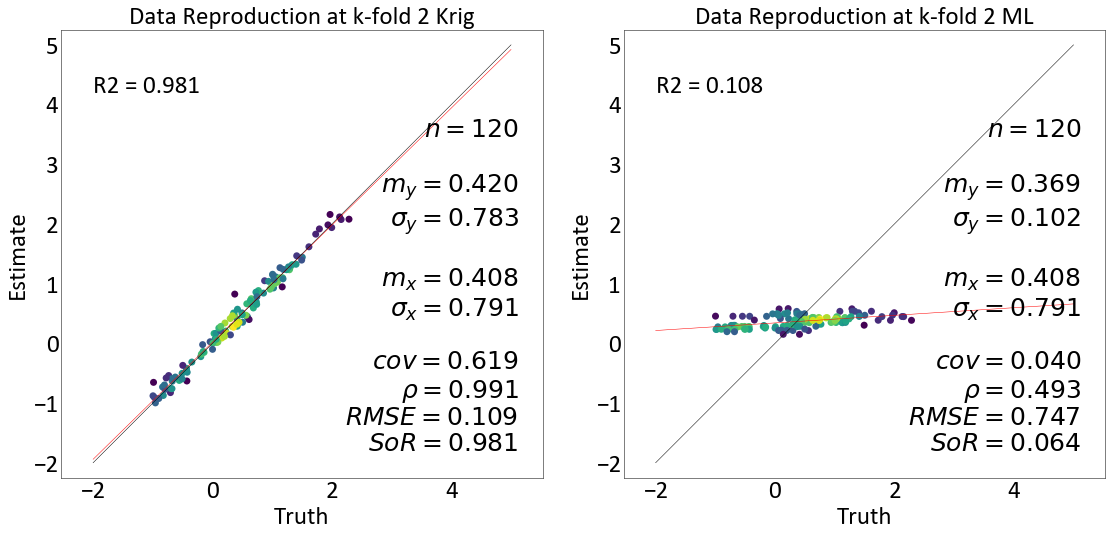

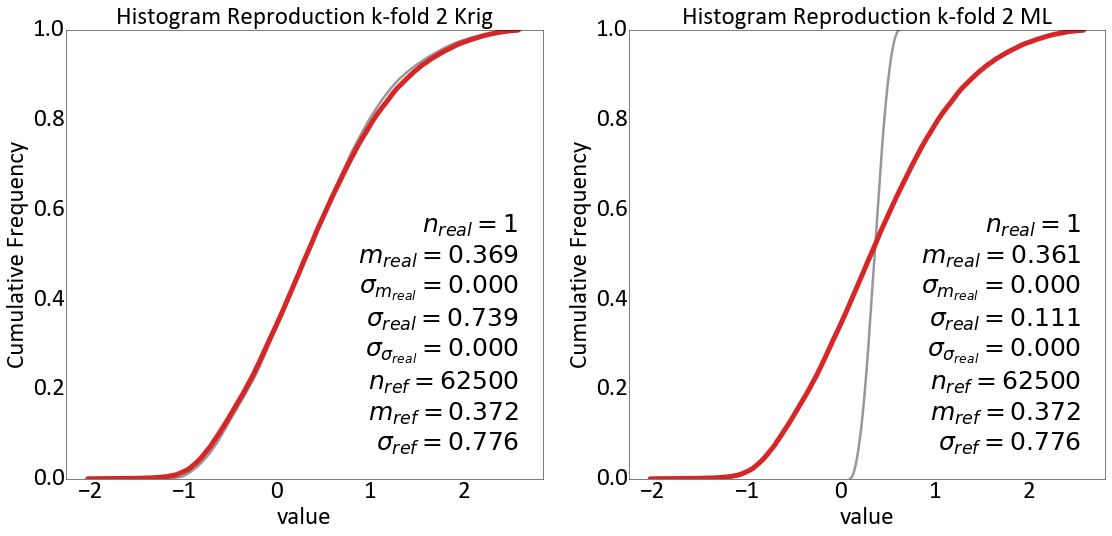

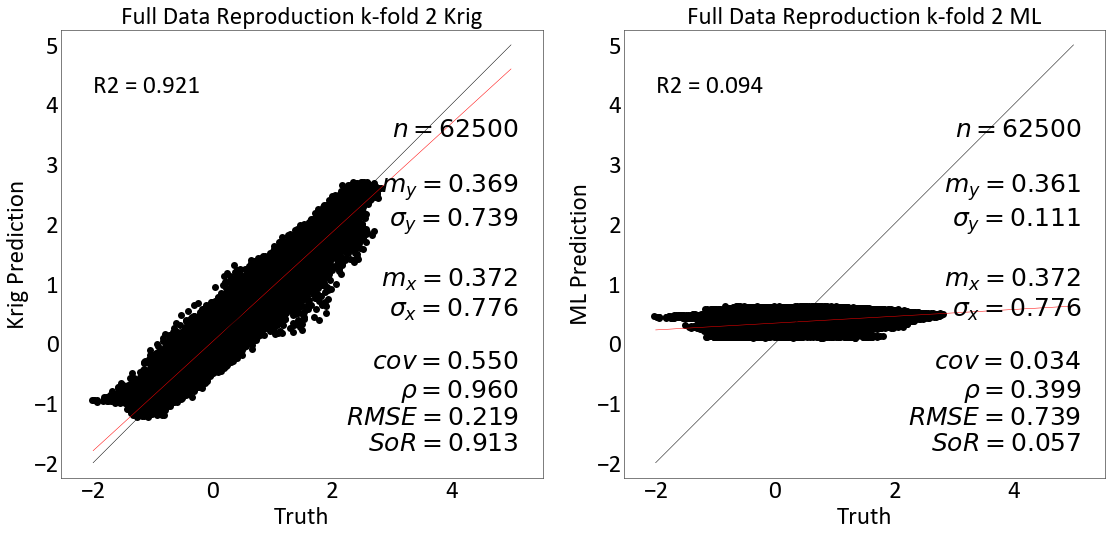

the r2 for krig k-fold 0.9809435971450797
the r2 for ML k-fold 0.10812802584583292
the r2 for krig full 0.9205954338976103
the r2 for ML full 0.09364360013612627


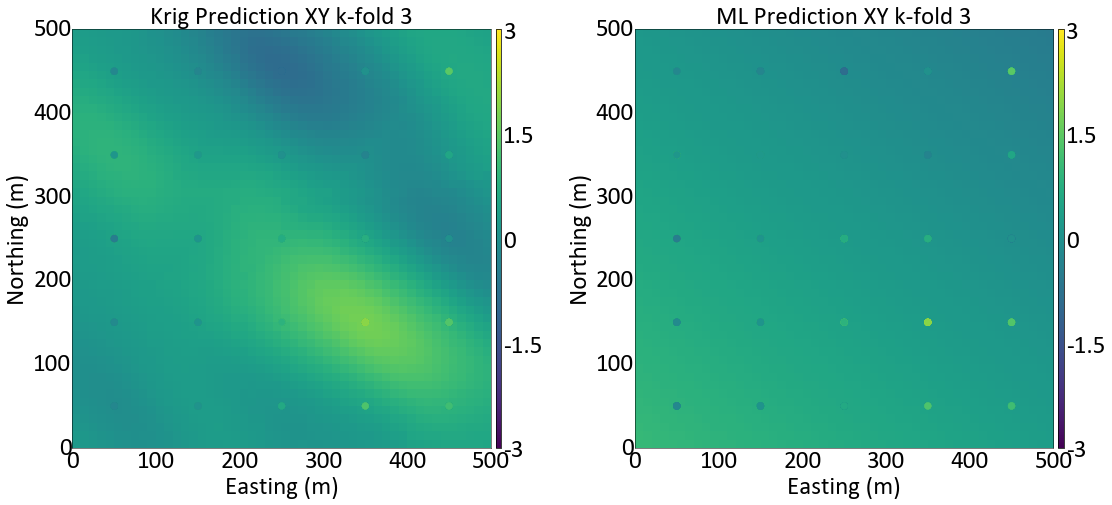

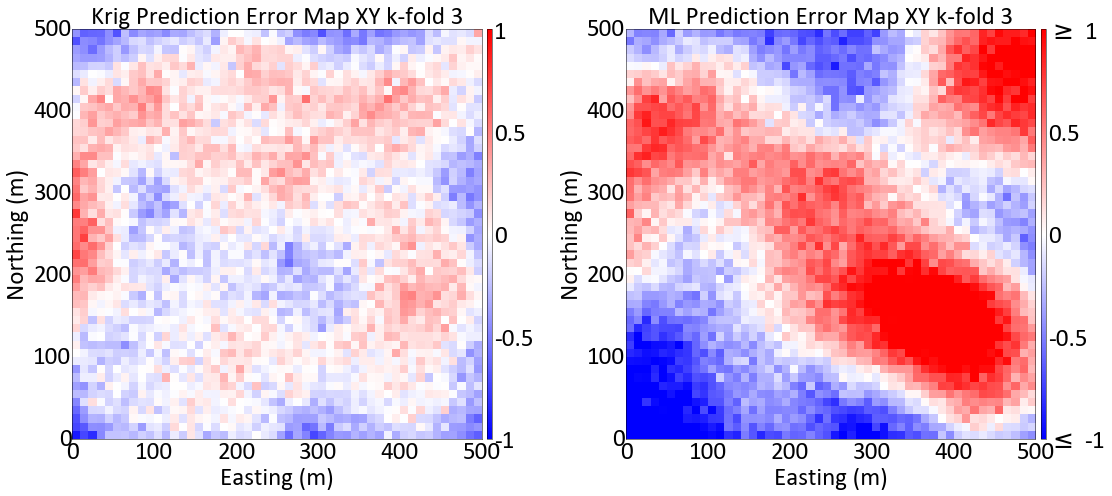

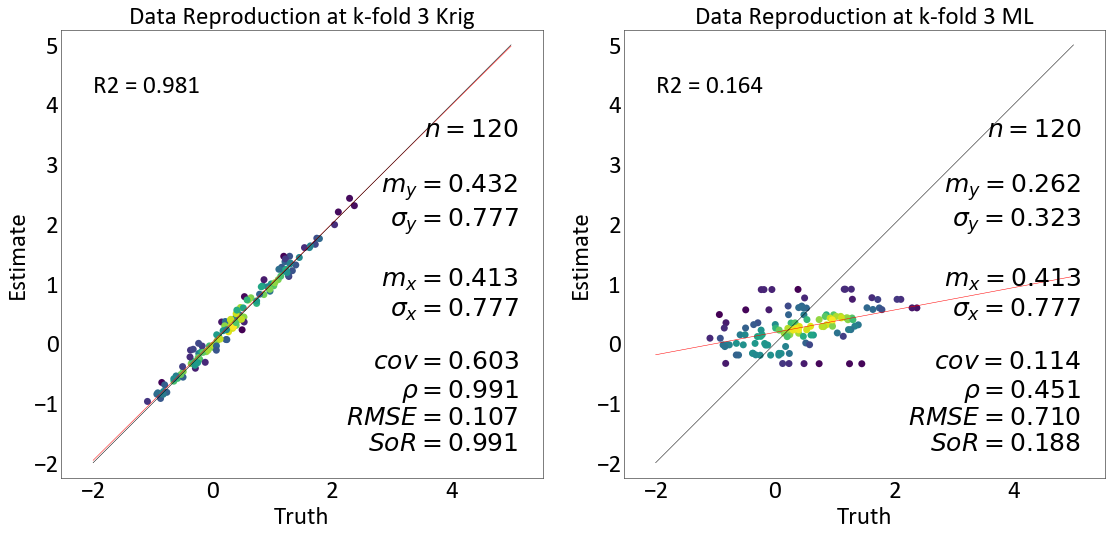

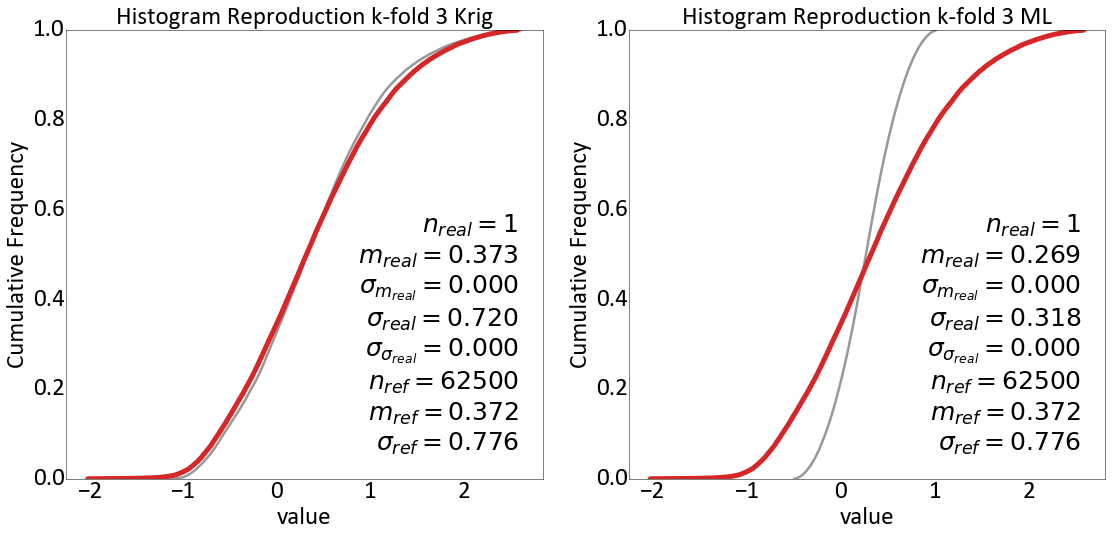

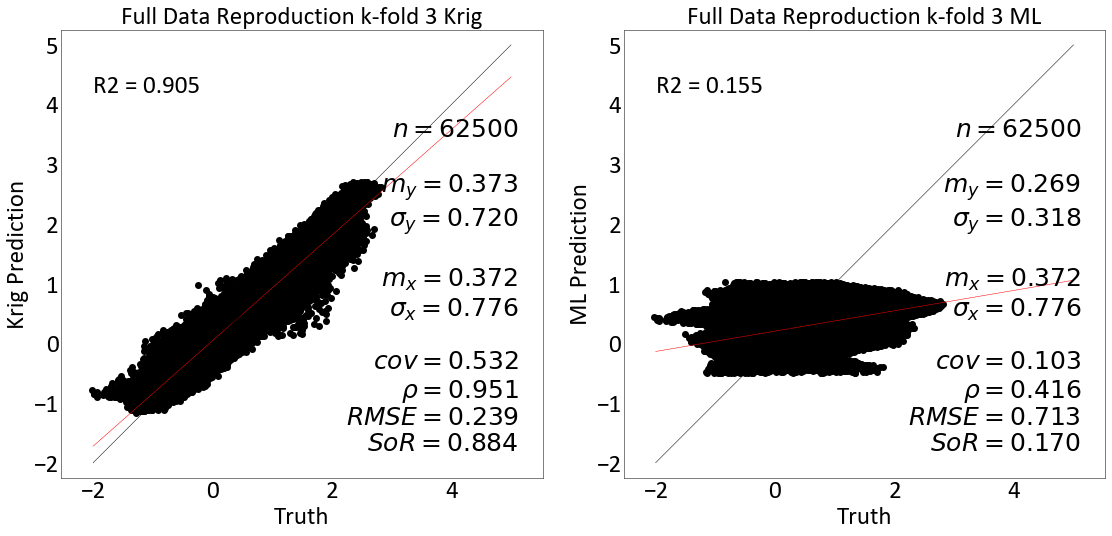

the r2 for krig k-fold 0.9809493941313647
the r2 for ML k-fold 0.16407923128802915
the r2 for krig full 0.9047980540024068
the r2 for ML full 0.1552711574186466


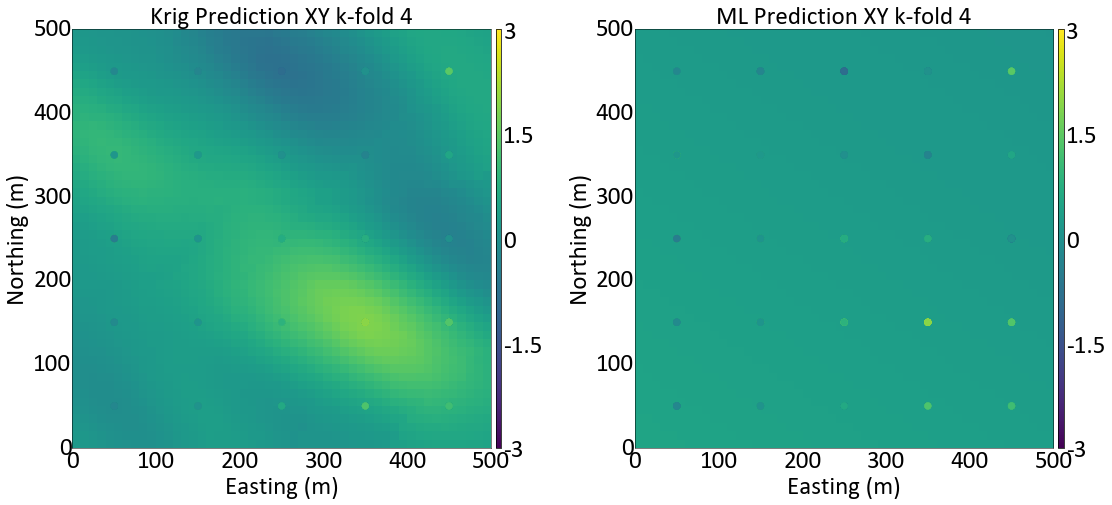

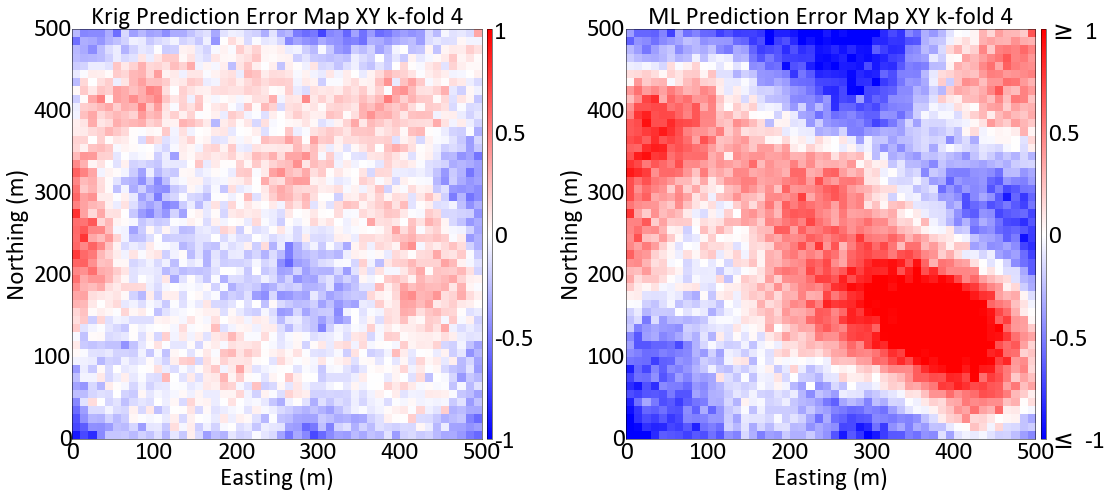

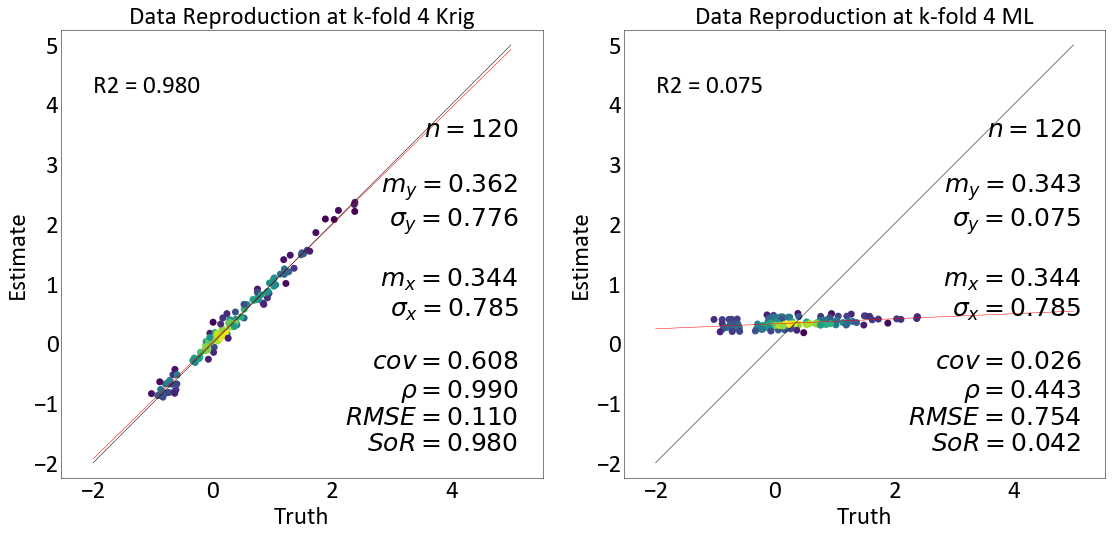

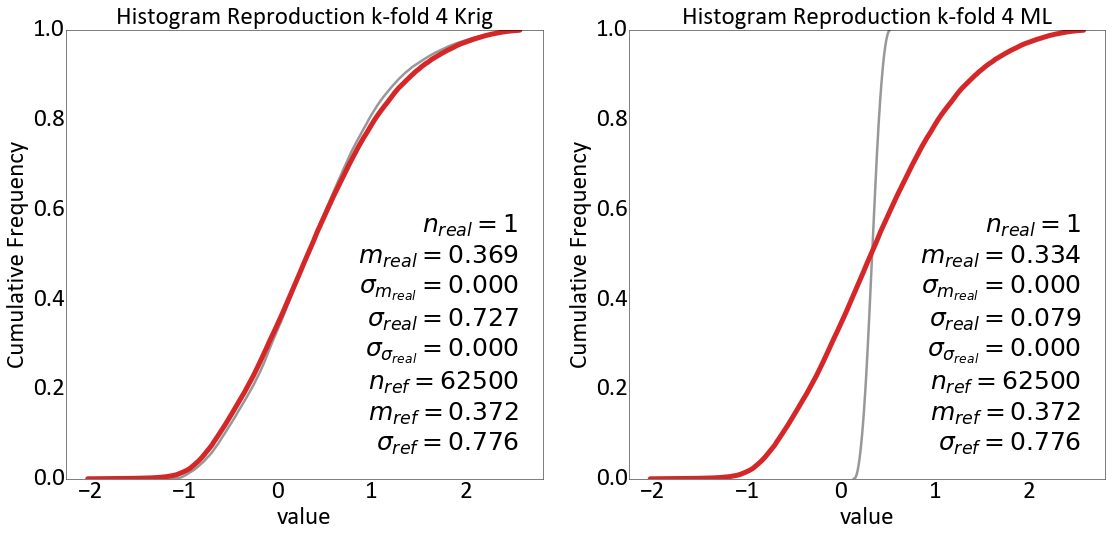

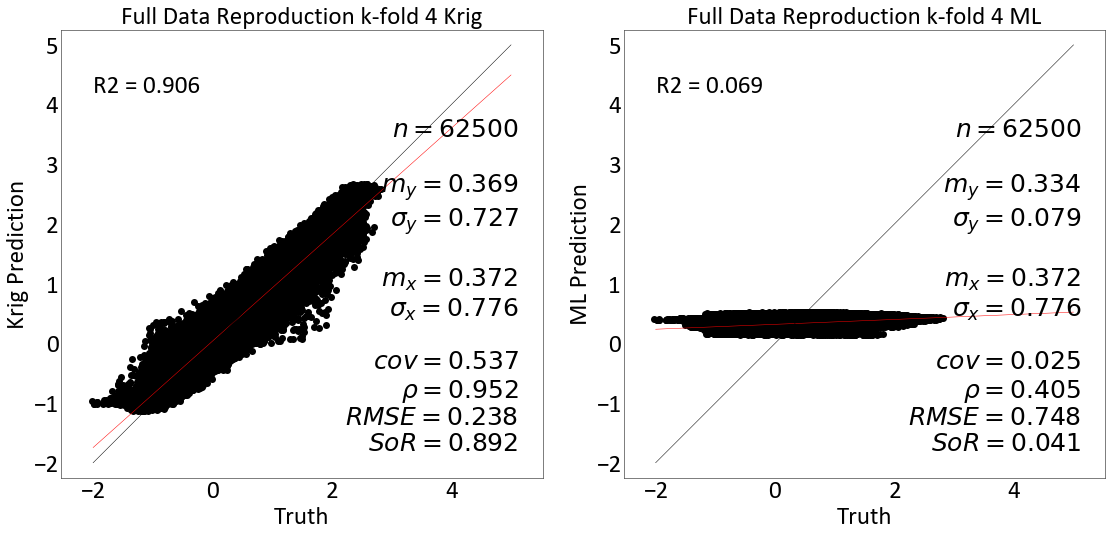

the r2 for krig k-fold 0.9802799107067265
the r2 for ML k-fold 0.0754309815030032
the r2 for krig full 0.9057215997373248
the r2 for ML full 0.06939332005734722


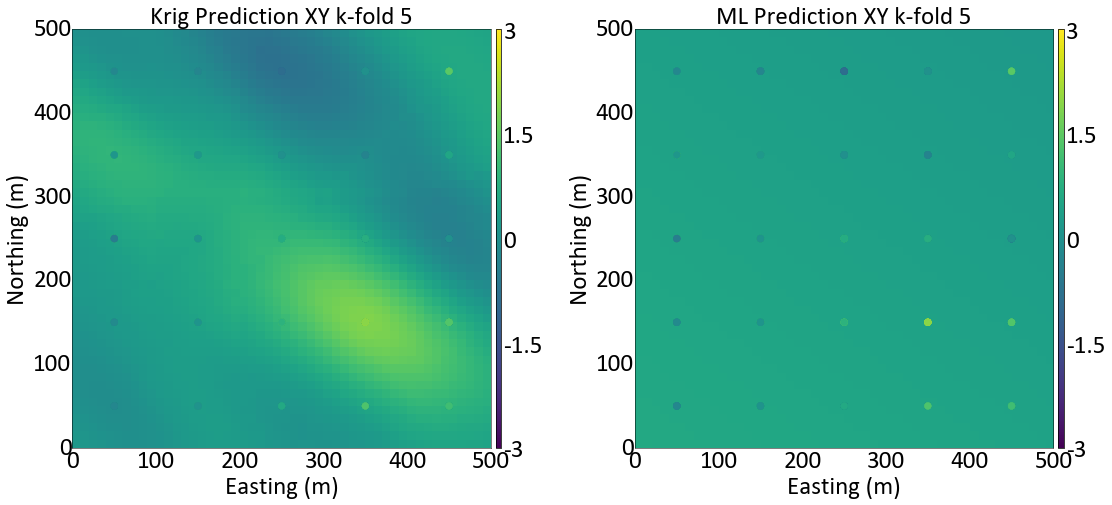

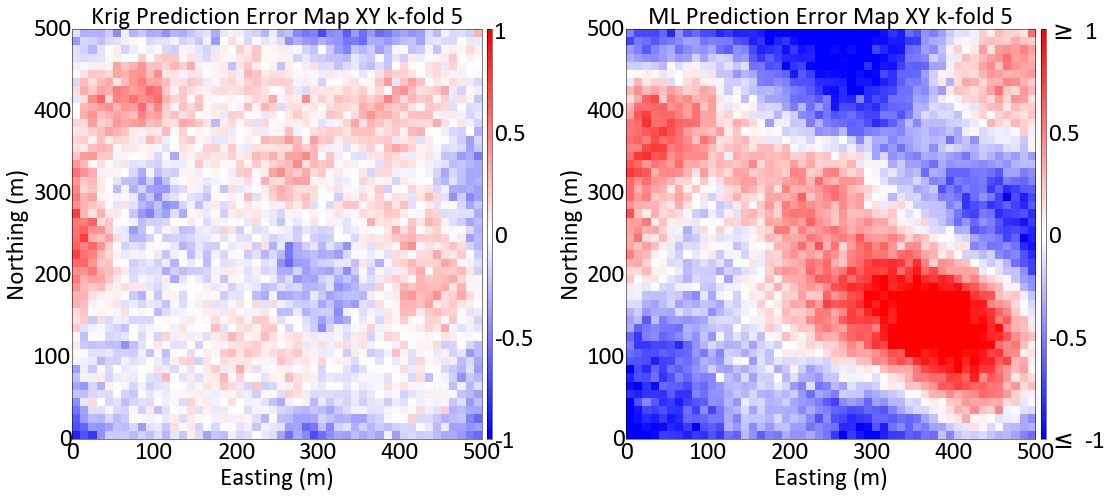

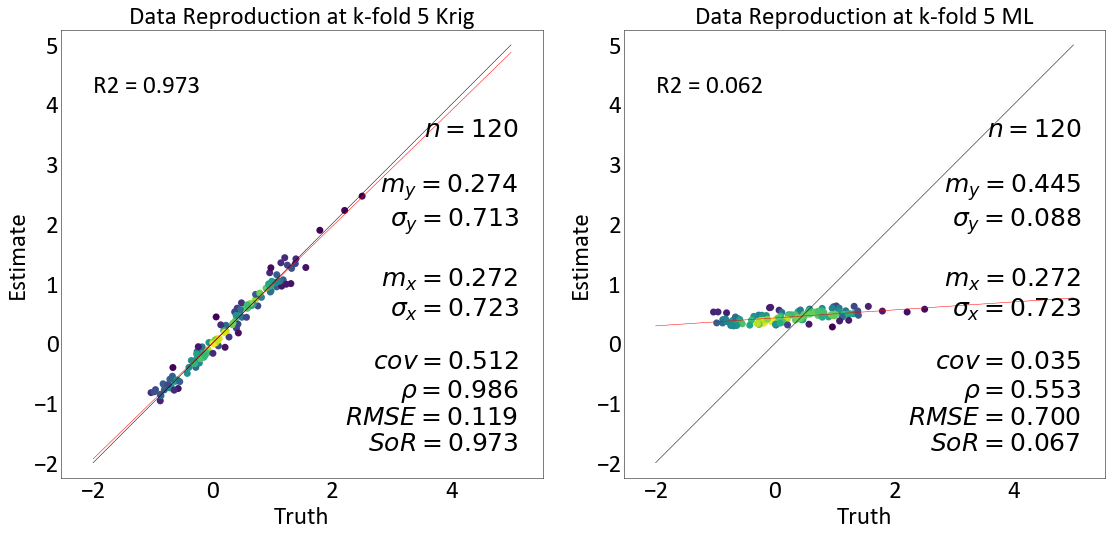

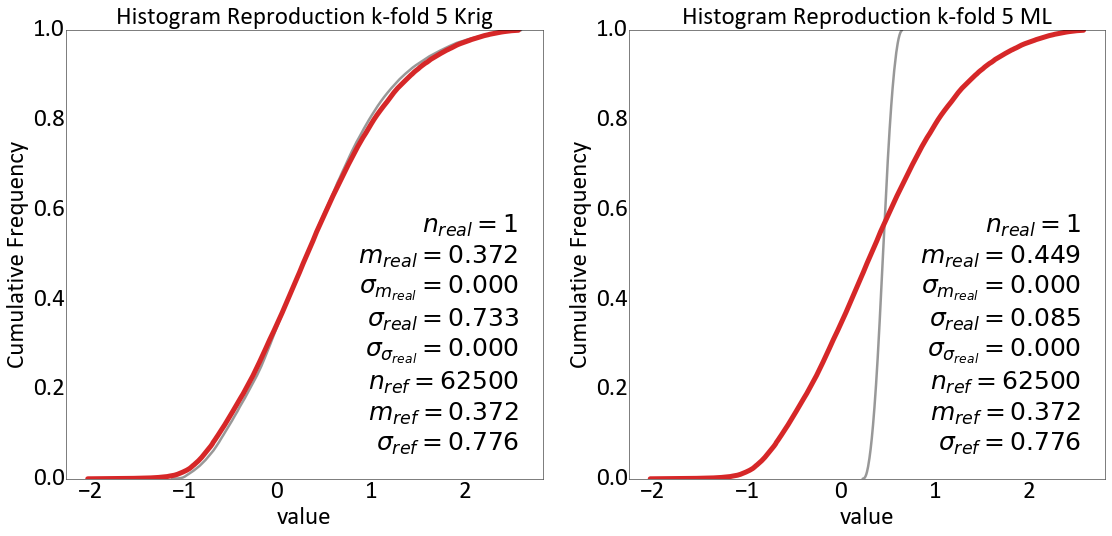

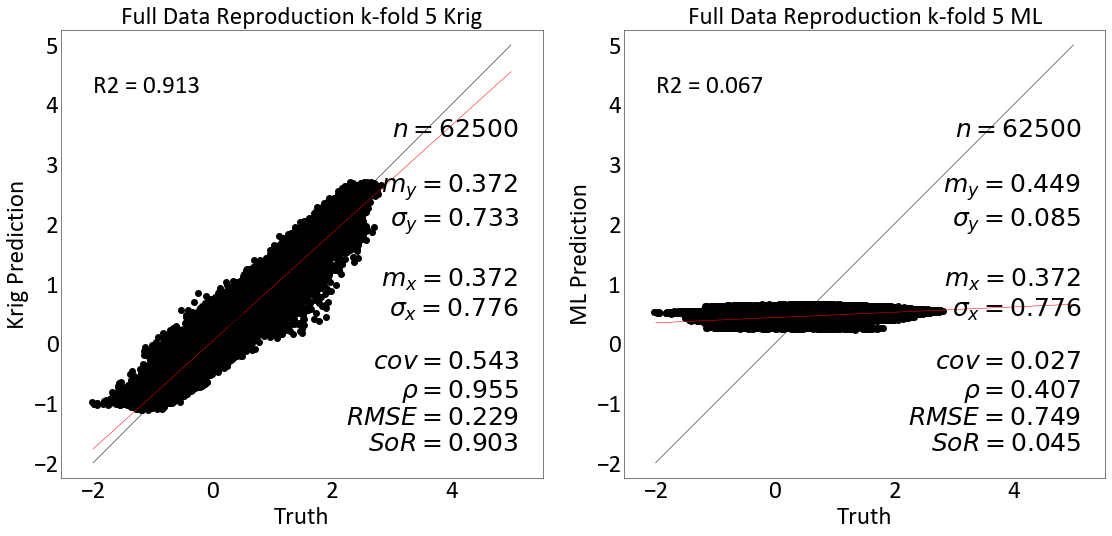

the r2 for krig k-fold 0.9728078269339622
the r2 for ML k-fold 0.06175011734241276
the r2 for krig full 0.9127302769725953
the r2 for ML full 0.06706642157878095
the average r2 of the krig is 0.9772253150181056
the average r2 of the ML is 0.0959969007369148
the average rmse of the krig is 0.11380745496787897
the average rmse of the ML is 0.7217608685255237
the average r2 of the full model for krig is 0.9097635175450884
the average r2 of the full model for ML is 0.09259629915140641
the average rmse of the full model for krig is 0.2330430314472541
the average rmse of the full model for ML is 0.7390014921961575


In [10]:
sgsimfl = gs.DataFile(flname = 'sgsim.out', griddef=griddef,readfl=True)
dataflpoints = gs.DataFile(flname='dhs.out', x='X',y='Y',z='Z', griddef = griddef,
                       readfl=True)
gs.set_style('pt25')
datasamplefl = pd.DataFrame(dataflpoints.data, dtype = np.float32)
del datasamplefl['Drill ID']
del datasamplefl['MD']
del datasamplefl['Block ID']
datasamplefl = datasamplefl[pd.notnull(datasamplefl['value'])]
datasamplefl.describe()
datatest = np.asmatrix(datasamplefl)
slinceno=20
vlim =(-3,3)
r2_krg = 0
r2_ML = 0
i=0
mse_krg = 0
mse_ML = 0
r2_krg_full = 0 
r2_ML_full = 0
mse_krg_full = 0
mse_ML_full = 0
mse_ML_icck = 0
r2_ML_icck = 0
r2_ML_icck_full = 0
mse_ML_icck_full = 0

var = 'value'
sigma = 0
for fold in range(1,6):
    i += 1
    testfile = gs.DataFile('./data/data_test_{}.dat'.format(fold))
    pltdat_kt3dn = gs.DataFile('./predictions/kt3dn_{}.out'.format(fold),griddef=griddef)
    pltdat_ml = gs.DataFile('./predictions/real_{}.dat'.format(fold),griddef=griddef)
    pltdat_ml = (gaussian_filter((pltdat_ml.data['0']),sigma = 0))
#    pltdat_ml[pltdat_ml < 0] = 0
#     pltdat_ml_icck = gs.DataFile('./backtr/backtr_UDDH_{}.out'.format(fold),griddef=griddef)
    idx,ingrid = griddef.coord_to_index1d(x=testfile.data['X'],y=testfile.data['Y'],z=testfile.data['Z'])
    f, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
#    axes[2].set_aspect('equal', 'box')

    ax2 = gs.pixelplt(pltdat_kt3dn,ax = axes[0],
                title = 'Krig Prediction XY k-fold {}'.format(fold),vlim=vlim, sliceno=slinceno)
    ax2 = gs.locmap(datasamplefl,griddef=griddef, ax=ax2,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'Krig Prediction XY k-fold {}'.format(fold))

    ax3 = gs.pixelplt(pltdat_ml,griddef=griddef,ax = axes[1],
                title = 'ML Prediction XY k-fold {}'.format(fold),vlim=vlim, sliceno=slinceno)
    ax3 = gs.locmap(datasamplefl,griddef=griddef, ax=ax3,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'ML Prediction XY k-fold {}'.format(fold))

    #ax4 = gs.pixelplt(pltdat_ml_icck,griddef=griddef,var = 'Back Transform' ,ax = axes[2],
                #title = 'ML prediction XY ensemble',vlim=vlim, sliceno=slinceno)
#    ax4 = gs.locmap(datasamplefl,griddef=griddef, ax=ax4,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'ML+ICCK prediction XY')
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/pix_xy_01_{}.png'.format(fold))
    plt.show()
    
    f, axes = plt.subplots(1, 2, figsize=(16, 8))

    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
#    axes[2].set_aspect('equal', 'box')
    
    ax2 = gs.pixelplt((sgsimfl.data['value']-pltdat_kt3dn.data['Estimate']),ax = axes[0],
                title = 'Krig Prediction Error Map XY k-fold {}'.format(fold),vlim=(-1,1), sliceno=slinceno, orient = 'xy',cmap = 'bwr',griddef=griddef)
    #ax2 = gs.locmap(datasamplefl,griddef=griddef, ax=ax2,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'krig prediction XY', orient = 'xz')

    ax3 = gs.pixelplt((sgsimfl.data['value']-pltdat_ml),griddef=griddef,ax = axes[1],
                title = 'ML Prediction Error Map XY k-fold {}'.format(fold),vlim=(-1,1), sliceno=slinceno, orient = 'xy',cmap = 'bwr')
    #ax3 = gs.locmap(datasamplefl,griddef=griddef, ax=ax3,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'ML prediction XY ensemble', orient = 'xz')
    
    #ax4 = gs.pixelplt(pltdat_ml_icck,griddef=griddef,var = 'Back Transform' ,ax = axes[2],
                #title = 'ML prediction XY ensemble',vlim=vlim, sliceno=slinceno, orient = 'xz')
#    ax4 = gs.locmap(datasamplefl,griddef=griddef, ax=ax4,sliceno=slinceno,x='X', y='Y', z='Z',orient = 'xz',var = var , vlim=vlim,title = 'ML+ICCK prediction XY')
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/error_xy_01_{}.png'.format(fold))
    plt.show()
    
    f, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
#    axes[2].set_aspect('equal', 'box')
    
    ax2 = gs.scatxval(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx].values,xlabel='Truth', ylabel='Estimate',
        title = 'Data Reproduction at k-fold {} Krig'.format(fold),dens=True,ax = axes[0],vlim=(-2,5))
    
    ax2.text(-2,4.2,'R2 = {0:.3f}'.format(r2_score(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx].values)),size=25)
    
    ax3 = gs.scatxval(testfile.data[var],pltdat_ml[idx],xlabel='Truth', ylabel='Estimate',
        title = 'Data Reproduction at k-fold {} ML'.format(fold),dens=True,ax = axes[1],vlim=(-2,5))
    ax3.text(-2,4.2,'R2 = {0:.3f}'.format(r2_score(testfile.data[var],pltdat_ml[idx])),size=25)
    
#    ax4 = gs.scatxval(testfile.data[var],pltdat_ml_icck.data['Back Transform'][idx].values,xlabel='Truth', ylabel='Estimate',
        #title = 'Data Reproduction at k-fold {} ML+ICCK'.format(fold),dens=True,ax = axes[2])
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/kfold_datarep_01_{}.png'.format(fold))
    plt.show()
    f, axes = plt.subplots(1, 2, figsize=(16, 8))
    ax2 = gs.histpltsim(pltdat_kt3dn.data['Estimate'],sgsimfl['value'],ax=axes[0],lw=5,title = 'Histogram Reproduction k-fold {} Krig'.format(fold),griddef=griddef,nreal=1)


    ax3 = gs.histpltsim(pltdat_ml,sgsimfl['value'],ax=axes[1],lw=5,title = 'Histogram Reproduction k-fold {} ML'.format(fold),griddef=griddef,nreal=1)
    
    
#    ax4 = gs.histpltsim(pltdat_ml_icck.data['Back Transform'],sgsimfl['Var1'],ax=axes[2],griddef=griddef,nreal=1)
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/histsim_01_{}.png'.format(fold))
    plt.show()
    
    f, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
#    axes[2].set_aspect('equal', 'box')
    
    ax2 = gs.scatxval(sgsimfl['value'],pltdat_kt3dn.data['Estimate'],ax=axes[0],griddef=griddef,xlabel='Truth',vlim=(-2,5),
                      title = 'Full Data Reproduction k-fold {} Krig'.format(fold), ylabel ='Krig Prediction',desn=True)
    ax2.text(-2,4.2,'R2 = {0:.3f}'.format(r2_score(sgsimfl['value'],pltdat_kt3dn.data['Estimate'])),size=25)

    ax3 = gs.scatxval(sgsimfl['value'],pltdat_ml,ax=axes[1],griddef=griddef,xlabel='Truth',ylabel='ML Prediction',vlim=(-2,5),
                      title = 'Full Data Reproduction k-fold {} ML'.format(fold),label ='ML Prediction',desn=True)
    ax3.text(-2,4.2,'R2 = {0:.3f}'.format(r2_score(sgsimfl['value'],pltdat_ml)),size=25)
    
#    ax4 = gs.scatxval(sgsimfl['Var1'],pltdat_ml_icck.data['Back Transform'],ax=axes[2],griddef=griddef,xlabel='Truth', ylabel ='ML+ICCK Prediction',vlim =vlim)
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/full_datarep_01_{}.png'.format(fold))
    plt.show()
    
    print('the r2 for krig k-fold {}'.format(r2_score(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx])))
    print('the r2 for ML k-fold {}'.format(r2_score(testfile.data[var],pltdat_ml[idx])))
    print('the r2 for krig full {}'.format(r2_score(sgsimfl['value'],pltdat_kt3dn.data['Estimate'])))
    print('the r2 for ML full {}'.format(r2_score(sgsimfl['value'],pltdat_ml)))
    
    
    
    mse_krg = mse_krg + mean_squared_error(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx])
    mse_ML = mse_ML + mean_squared_error(testfile.data[var],pltdat_ml[idx])
#    mse_ML_icck = mse_ML_icck + mean_squared_error(testfile.data[var],pltdat_ml_icck.data['Back Transform'][idx])
    r2_krg = r2_krg + r2_score(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx])
    r2_ML = r2_ML + r2_score(testfile.data[var],pltdat_ml[idx])
#    r2_ML_icck = r2_ML_icck + r2_score(testfile.data[var],pltdat_ml_icck.data['Back Transform'][idx])
    r2_krg_full = r2_krg_full + r2_score(sgsimfl['value'],pltdat_kt3dn.data['Estimate'])
    r2_ML_full = r2_ML_full + r2_score(sgsimfl['value'],pltdat_ml)
#    r2_ML_icck_full = r2_ML_icck_full + r2_score(sgsimfl['Var1'].values,pltdat_ml_icck.data['Back Transform'].values)
    mse_krg_full = mse_krg_full + mean_squared_error(sgsimfl['value'],pltdat_kt3dn.data['Estimate'])
    mse_ML_full = mse_ML_full + mean_squared_error(sgsimfl['value'],pltdat_ml)
#     mse_ML_icck_full = mse_ML_icck_full + mean_squared_error(sgsimfl['Var1'],pltdat_ml_icck.data['Back Transform'])
    
    gs.write_gslib(pd.DataFrame(pltdat_ml),'./predictions/ML_pred_{}.dat'.format(fold))
    
print('the average r2 of the krig is {}'.format(r2_krg/i))
print('the average r2 of the ML is {}'.format(r2_ML/i))
#print('the average r2 of the ML_ICCK is {}'.format(r2_ML_icck/i))
print('the average rmse of the krig is {}'.format(np.sqrt(mse_krg/i)))
print('the average rmse of the ML is {}'.format(np.sqrt(mse_ML/i)))
#print('the average rmse of the ML_icck is {}'.format(np.sqrt(mse_ML_icck/i)))
print('the average r2 of the full model for krig is {}'.format(r2_krg_full/i))
print('the average r2 of the full model for ML is {}'.format(r2_ML_full/i))
#print('the average r2 of the full model for ML_icck is {}'.format(r2_ML_icck_full/i))
print('the average rmse of the full model for krig is {}'.format(np.sqrt(mse_krg_full/i)))
print('the average rmse of the full model for ML is {}'.format(np.sqrt(mse_ML_full/i)))
#print('the average rmse of the full model for ML_icck is {}'.format(np.sqrt(mse_ML_icck_full/i)))

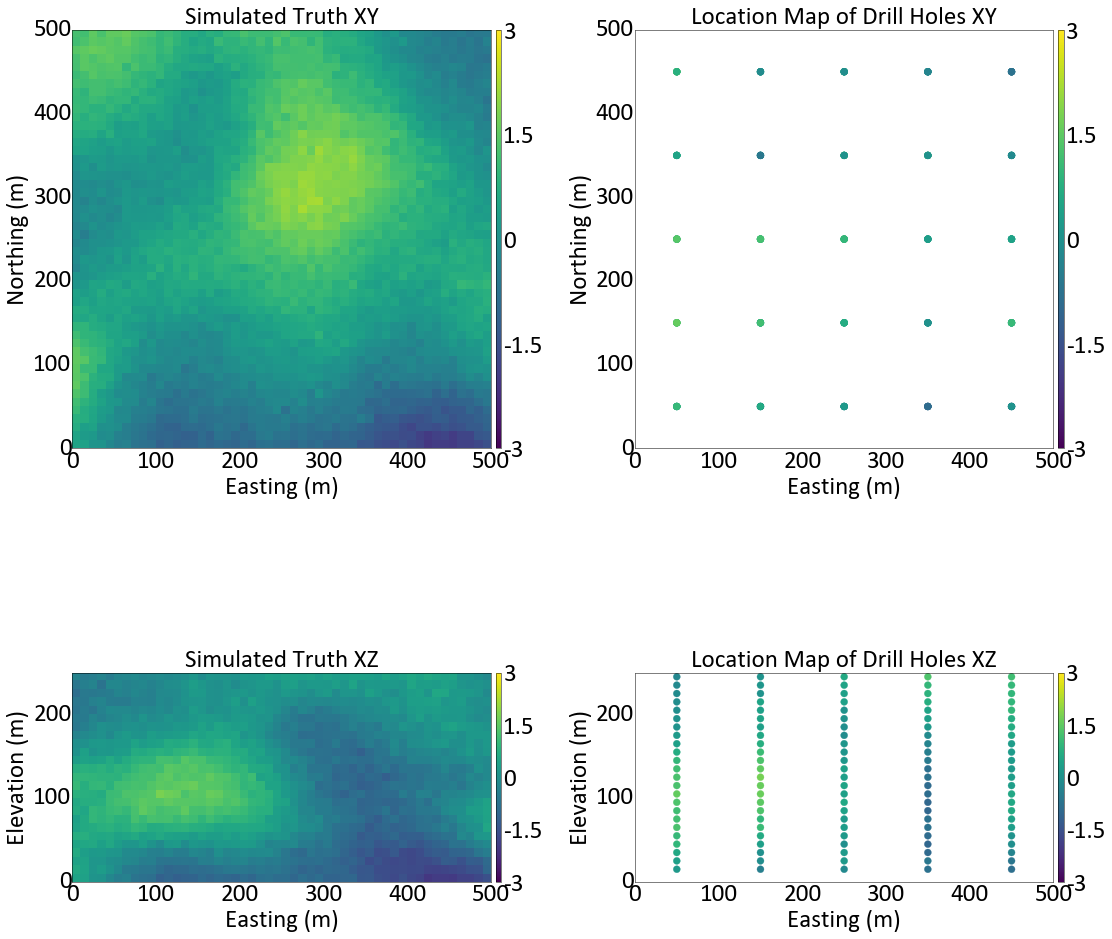

In [365]:
dataflpoints = gs.DataFile(flname='dhs.out', x='X',y='Y',z='Z', griddef = griddef,
                       readfl=True)
f, axes = plt.subplots(2, 2, figsize=(16, 16))
gs.pixelplt(sgsimfl.data['value'], vlim=vlim, ax = axes[0,0], griddef = griddef,  title = 'Simulated Truth XY')
gs.locmap(dataflpoints,var = 'value' ,vlim=vlim, ax = axes[0,1], griddef = griddef,orient='xy', title = 'Location Map of Drill Holes XY')
gs.pixelplt(sgsimfl.data['value'], vlim=vlim, ax = axes[1,0], griddef = griddef,orient='xz', title = 'Simulated Truth XZ')
gs.locmap(dataflpoints,var = 'value' ,vlim=vlim, ax = axes[1,1], griddef = griddef,orient='xz', title = 'Location Map of Drill Holes XZ')
plt.tight_layout()
plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/Data_01.png')
plt.show()

In [367]:
varsim = gs.Program('varsim')
varsimparstr = """                 Parameters for VarSim
                 *********************

START OF PARAMETERS:
../data/lithology.dat        -file with lithology information
0   7                        -   lithology column (0=not used), code
{datafl}             -file with data
1   1                -   number of variables, column numbers
-1.0e21     1.0e21    -   trimming limits
./vargs/varsim_reals_{p_type}_{fold}.out      -output file for variograms of realizations
./vargs/varsim_avg_{p_type}_{fold}.out        -output file for average variogram
{griddef}
1                  -number of realizations
3  100                 -number of directions, number of lags
1  0  0              -ixd(1),iyd(1),izd(1)
0  1  0              -ixd(2),iyd(2),izd(2)
0  0  1              -ixd(2),iyd(2),izd(2)
0                     -standardize sill? (0=no, 1=yes)
1                     -number of variograms
1   1   1             -tail variable, head variable, variogram type
"""

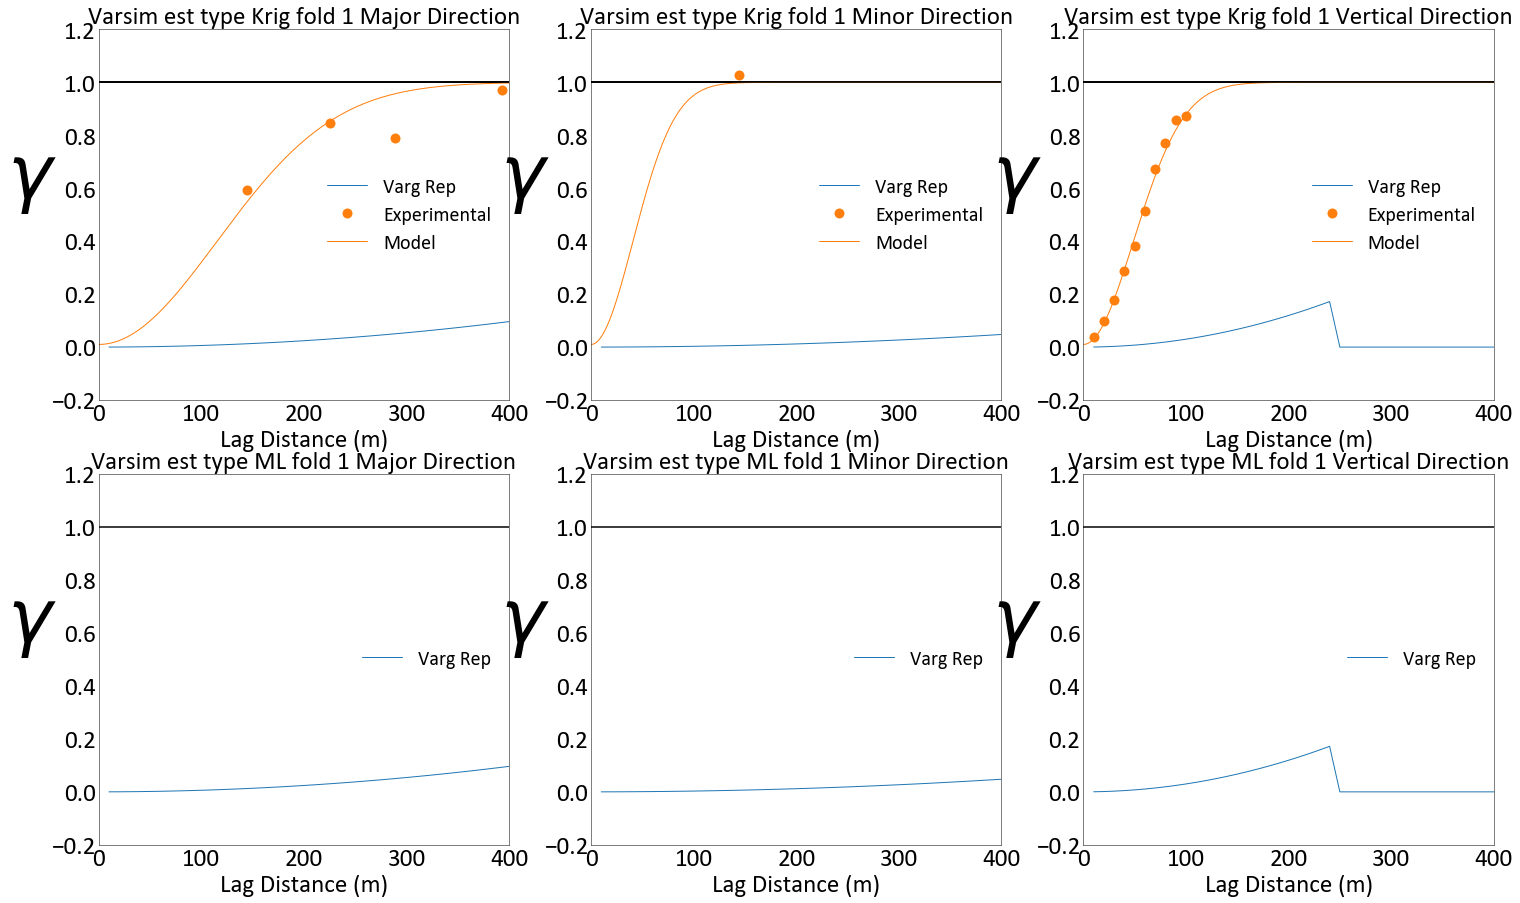

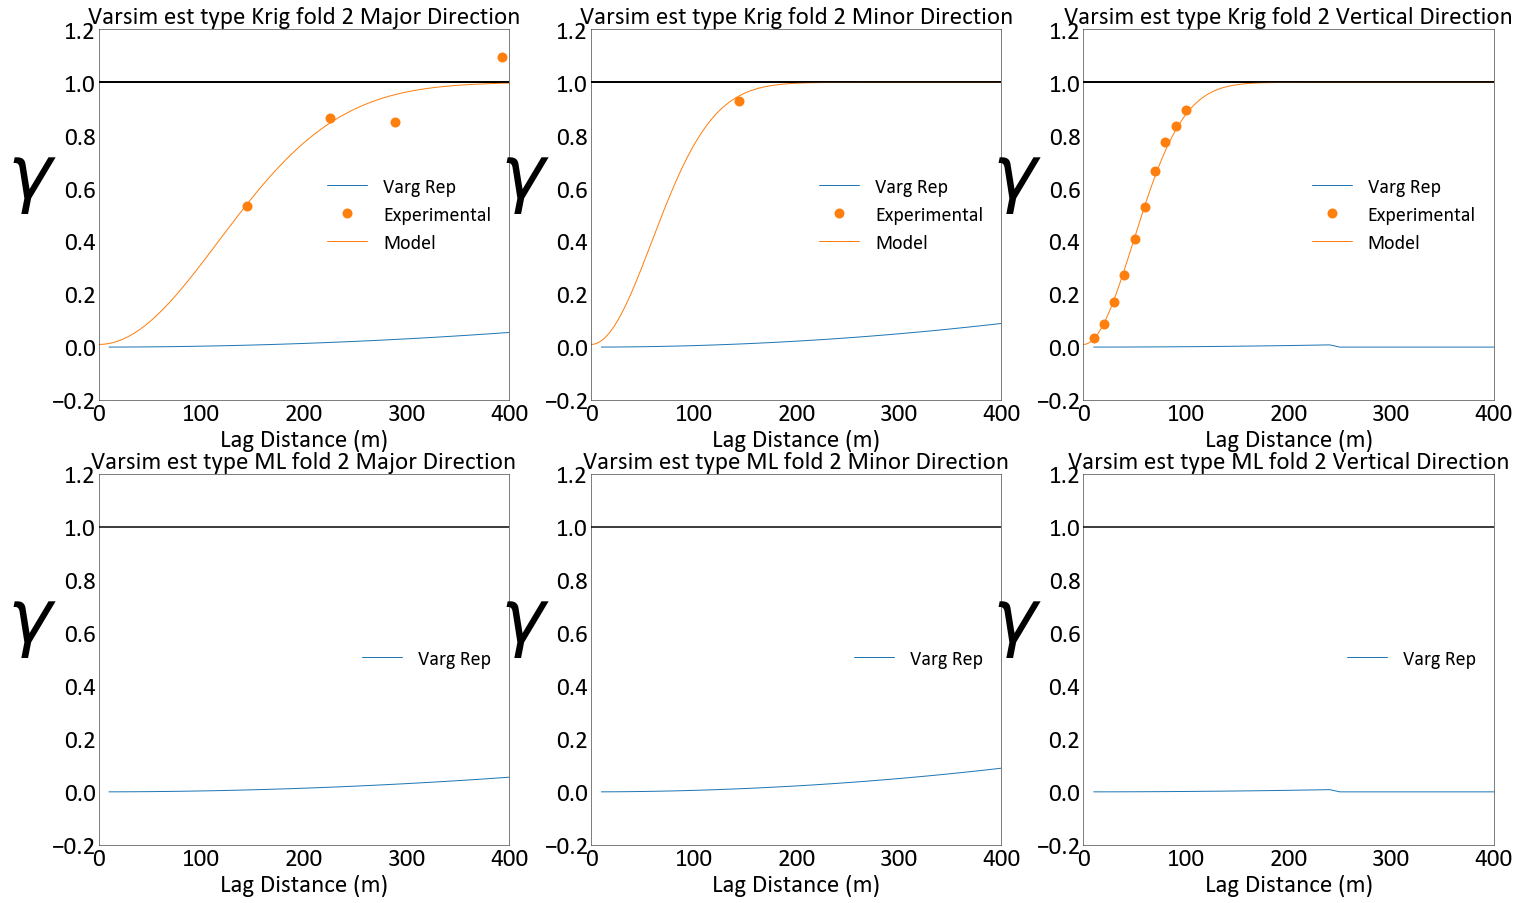

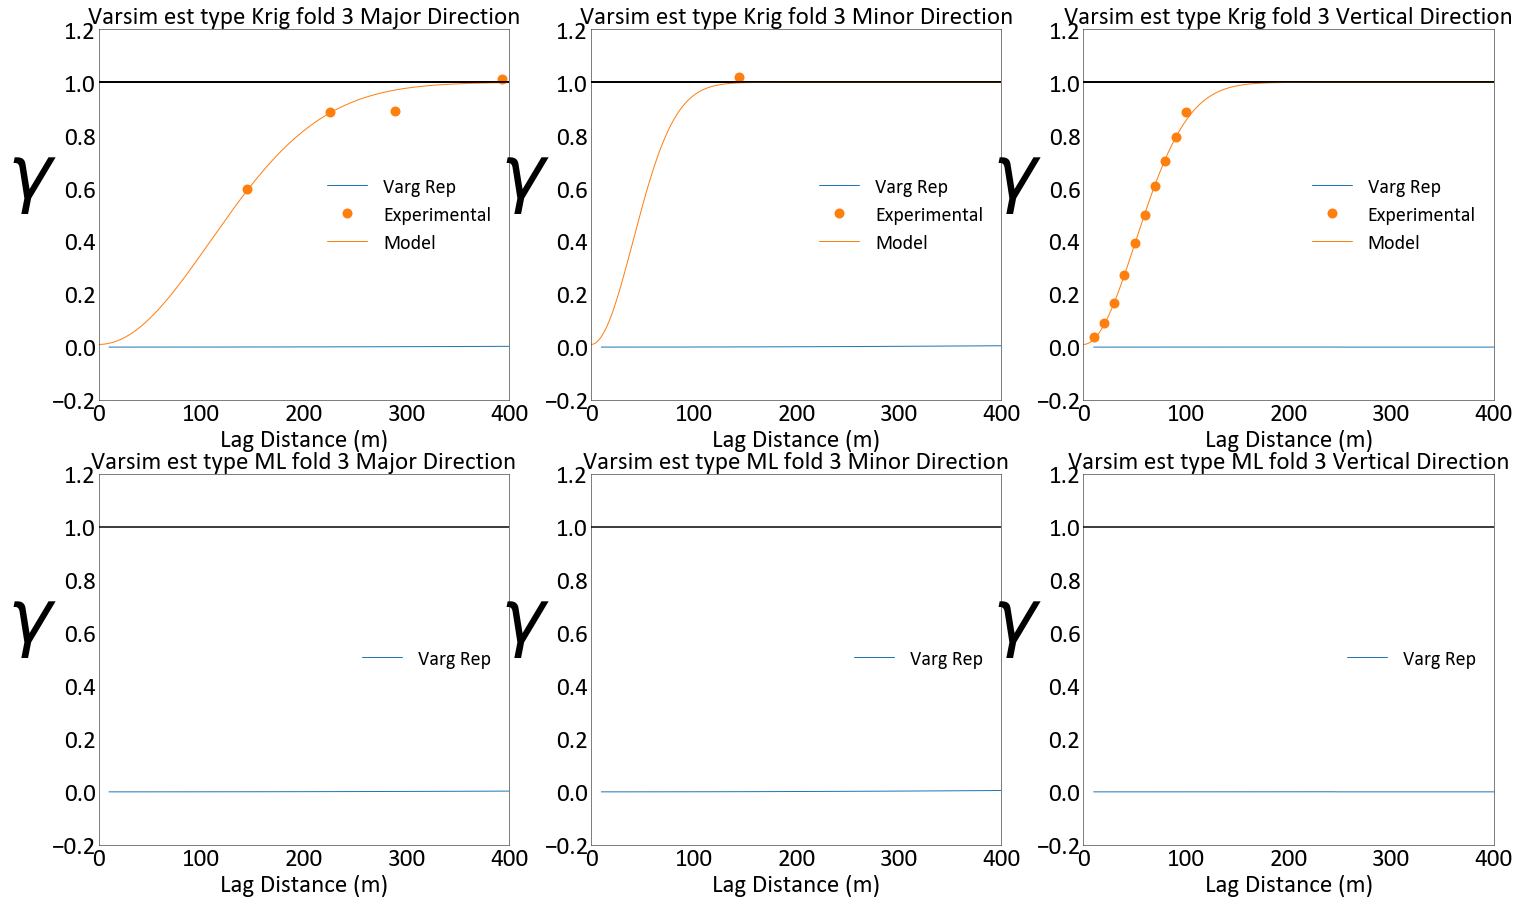

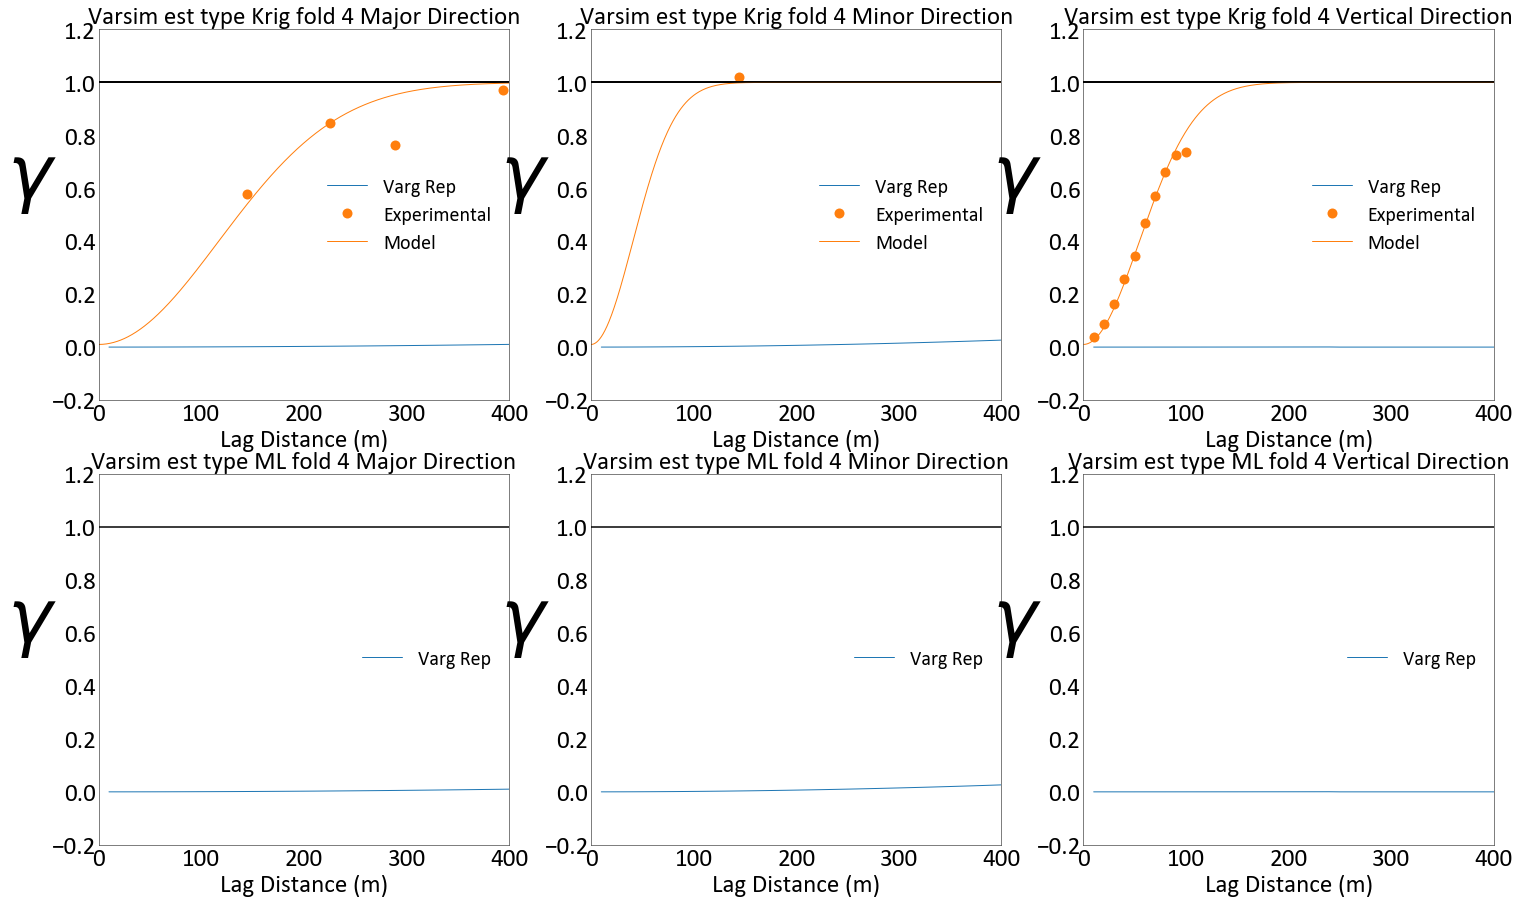

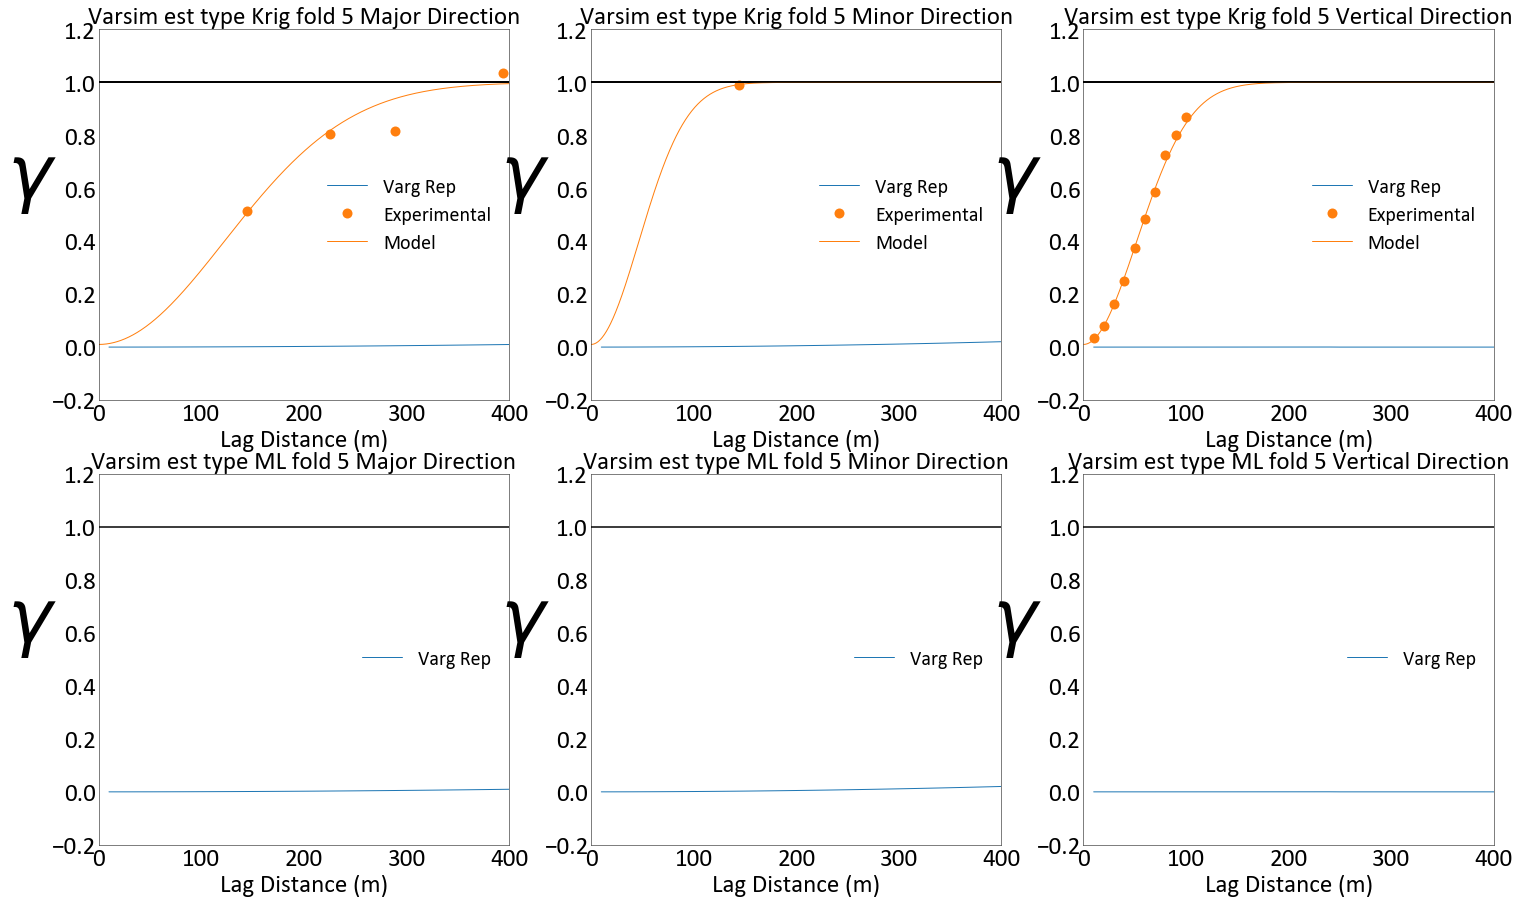

In [404]:
ylim = (-.2,1.2)
for fold in range(1,6):
    varmodelfl = gs.DataFile('./vargs/varmodel_{}.out'.format(fold))
    varcalcfl = gs.DataFile('./vargs/varcalc_{}.out'.format(fold))
    f, axes = plt.subplots(2, 3, figsize=(25, 15))
    for p_type in list(['Krig','ML']):
        if p_type == 'Krig':
            predfile = gs.DataFile('./predictions/kt3dn_{}.out'.format(fold),griddef=griddef)
            
        if p_type == 'ICCK+ML':
            predfile = gs.DataFile('./backtr/backtr_{}.out'.format(fold),griddef=griddef)
        else:
            predfile = gs.DataFile('./predictions/ML_pred_{}.dat'.format(fold),griddef=griddef)
            
        varsim.run(varsimparstr.format(datafl = predfile,
                                       p_type = p_type,
                                       fold = fold,
                                       griddef = griddef),quiet=True,liveoutput=False)
        varsimfl =  gs.DataFile('./vargs/varsim_reals_{}_{}.out'.format(p_type,fold))
    

        if p_type == 'Krig':
            ax = gs.varplt(varsimfl,experimental=False,color ='C0' ,index = 1,ax =axes[0,0],ms = 10, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            ax = gs.varplt(varcalcfl.data,index = 1,ax =ax,color ='C1' ,ms = 10, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold),label= 'Experimental',ylim=ylim)
            ax = gs.varplt(varmodelfl,experimental=False,color ='C1' ,index = 1,ax =ax, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold),label= 'Model',ylim=ylim)
            ax.legend(loc=7,prop={'size': 20})
            ax.set_xlim(0, 400)
            
            ax2 = gs.varplt(varsimfl,experimental=False,color ='C0' ,ms = 10,index = 2,ax =axes[0,1], title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            ax2 = gs.varplt(varcalcfl.data,index = 2,ax =ax2,color ='C1' ,ms = 10, title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold),label= 'Experimental',ylim=ylim)
            ax2 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10,index = 2,ax =ax2, title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold),label= 'Model',ylim=ylim)
            ax2.legend(loc=7,prop={'size': 20})
            ax2.set_xlim(0, 400)
            
            ax3 = gs.varplt(varsimfl,experimental=False,color ='C0' ,ms = 10, index = 3,ax =axes[0,2], title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            ax3 = gs.varplt(varcalcfl.data,index = 3,ax =ax3,color ='C1' ,ms = 10,  title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold),label= 'Experimental',ylim=ylim)
            ax3 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10, index = 3,ax =ax3, title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold),label= 'Model',ylim=ylim)
            ax3.legend(loc=7,prop={'size': 20})
            ax3.set_xlim(0, 400)
            
        if p_type == 'ML':
            ax4 = gs.varplt(varsimfl,experimental=False,color ='C0' ,index = 1,ax = axes[1,0],ms = 10, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            #ax = gs.varplt(varcalcfl.data,index = 1,ax =ax,color ='C1' ,ms = 10, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold),label= 'Experimental')
            #ax = gs.varplt(varmodelfl,experimental=False,color ='C1' ,index = 1,ax =ax, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold),label= 'Model')
            ax4.legend(loc=7,prop={'size': 20})
            ax4.set_xlim(0, 400)
            ax5 = gs.varplt(varsimfl,experimental=False,color ='C0' ,ms = 10,index = 2,ax = axes[1,1], title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            #ax2 = gs.varplt(varcalcfl.data,index = 2,ax =ax2,color ='C1' ,ms = 10, title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold),label= 'Experimental')
            #ax2 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10,index = 2,ax =ax2, title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold),label= 'Model')
            ax5.legend(loc=7,prop={'size': 20})
            ax5.set_xlim(0, 400)
            ax6 = gs.varplt(varsimfl,experimental=False,color ='C0' ,ms = 10, index = 3,ax = axes[1,2], title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            #ax3 = gs.varplt(varcalcfl.data,index = 3,ax =ax3,color ='C1' ,ms = 10,  title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold),label= 'Experimental')
            #ax3 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10, index = 3,ax =ax3, title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold),label= 'Model')
            ax6.legend(loc=7,prop={'size': 20})
            ax6.set_xlim(0, 400)


        
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/varg_rep_01_{}.png'.format(fold))
    plt.show()
